**Introduction**

The aim of this exercise is to code an execution algorithmic strategy that tries to achieve an execution cost close to the VWAP market benchmark (Volume Weighted Average Price). It follows the optimal execution strategy to track VWAP discussed in Busseti & Boyd (2015), see the notes of the course for details.

Delivery: Jupyter notebook (Python) with all the compulsory parts of the exercise and results

**Data reading and preparation**

Import the csv file “volume_price_2014_18.csv” required for the exercise. It contains four columns: date, time, volume and price. Load it into a Pandas dataframe. The data corresponds to market volumes and volume weighted average prices for intervals of one minute from 2014 to 2018. Perform an exploratory analysis in order to detect potential issues (hint: days with zero volume). Discard any anomaly you think it can affect the quality of the analysis.

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Configurar el estilo de matplotlib para modo oscuro
plt.style.use('dark_background')

class ExecutionAlgorithm:
    def __init__(self, file_path, train_end_date):
        """
        Inicializa la clase ExecutionAlgorithm con la ruta del archivo de datos y la fecha límite para dividir el conjunto de datos.
        
        Args:
            file_path (str): Ruta del archivo CSV con los datos de volumen y precio.
            train_end_date (str): Fecha límite para dividir los datos en entrenamiento y prueba.
        """
        self.file_path = file_path
        self.train_end_date = pd.Timestamp(train_end_date)
        self.data_df = None
        self.filtered_df = None
        self.resampled_df = None
        self.train_df = None
        self.test_df = None
        self.static_volume_curve = None
        self.normalized_volume_curve_result = None

    def load_data(self):
        """
        Carga los datos desde el archivo CSV y maneja excepciones si el archivo no existe o está vacío.
        """
        try:
            # Intentar cargar el archivo CSV
            self.data_df = pd.read_csv(self.file_path)
        except FileNotFoundError:
            # Manejar el caso en el que el archivo no se encuentra
            print(f"Error: El archivo {self.file_path} no fue encontrado.")
        except pd.errors.EmptyDataError:
            # Manejar el caso en el que el archivo está vacío
            print(f"Error: El archivo {self.file_path} está vacío.")
        except Exception as e:
            # Manejar cualquier otra excepción que ocurra durante la carga del archivo
            print(f"Error al leer el archivo: {e}")

    def preprocess_data(self):
        """
        Filtra los datos y realiza cálculos previos al análisis, como el cálculo del VWAP.
        - Elimina valores faltantes.
        - Filtra filas con volumen mayor a 0.
        - Calcula la columna 'vol_price' para el cálculo del VWAP.
        - Convierte las columnas de tiempo y fecha a sus formatos adecuados.
        - Agrupa los datos en intervalos de 5 minutos y calcula el VWAP.
        """
        if self.data_df is not None:
            # Manejar valores faltantes eliminando filas con datos faltantes
            self.data_df = self.data_df.dropna()
            # Filtrar filas con volumen mayor a 0
            self.filtered_df = self.data_df[self.data_df['volume'] > 0].copy()
            # Crear la columna vol_price para el VWAP
            self.filtered_df['vol_price'] = self.filtered_df['volume'] * self.filtered_df['price']
            # Convertir las columnas de tiempo y fecha a sus formatos adecuados
            self.filtered_df['time'] = pd.to_timedelta(self.filtered_df['time'])
            self.filtered_df['date'] = pd.to_datetime(self.filtered_df['date'])
            # Crear columna 'time_5min' para redondear a intervalos de 5 minutos
            self.filtered_df['time_5min'] = self.filtered_df['time'].dt.floor('5min')
            # Agrupar por 'date' y 'time_5min' para sumar el volumen y vol_price
            self.resampled_df = self.filtered_df.groupby(['date', 'time_5min']).agg({
                'volume': 'sum',
                'vol_price': 'sum'
            }).reset_index()
            # Calcular el VWAP
            self.resampled_df['vwap'] = self.resampled_df['vol_price'] / self.resampled_df['volume']
            # Eliminar filas con volumen igual a 0 después del resampleo
            self.resampled_df = self.resampled_df[self.resampled_df['volume'] > 0]
            # Eliminar la columna vol_price ya que ya no es necesaria
            self.resampled_df = self.resampled_df.drop(columns=['vol_price'])
        else:
            print("Error: No se han cargado datos para procesar.")

    def split_data(self):
        """
        Divide los datos en conjuntos de entrenamiento y prueba según la fecha límite especificada.
        """
        if self.resampled_df is not None:
            # Dividir los datos en entrenamiento y prueba utilizando la fecha límite
            self.train_df = self.resampled_df[self.resampled_df['date'] < self.train_end_date].copy()
            self.test_df = self.resampled_df[self.resampled_df['date'] >= self.train_end_date].copy()
            # Mostrar el número de filas en cada conjunto
            print(f"El dataset de entrenamiento tiene: {len(self.train_df)} filas y el de testeo tiene: {len(self.test_df)} filas")
        else:
            print("Error: No se han procesado datos para dividir.")

    def evaluate_model(self):
        """
        Evaluación básica del conjunto de datos dividido, mostrando las primeras filas del conjunto de entrenamiento y prueba.
        """
        if self.train_df is not None and self.test_df is not None:
            # Mostrar la primera fila del conjunto de entrenamiento
            print("Primera fila de train_df:")
            print(self.train_df.head(1))
            # Mostrar la primera fila del conjunto de prueba
            print("\nPrimera fila de test_df:")
            print(self.test_df.head(1))
        else:
            print("Error: No se han dividido los datos para evaluar.")

    def plot_training_volume_histogram(self):
        """
        Para cada día en el conjunto de entrenamiento, calcula el volumen total del mercado del día y grafica el histograma.
        """
        if self.train_df is not None:
            # Calcular el volumen total por día en el conjunto de entrenamiento
            daily_volume = self.train_df.groupby('date')['volume'].sum()

            # Crear el histograma usando matplotlib
            plt.figure(figsize=(8, 4))
            plt.hist(daily_volume, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            plt.title('Histograma del Volumen Diario Total en el Conjunto de Entrenamiento', fontsize=14)
            plt.xlabel('Volumen Diario Total', fontsize=12)
            plt.ylabel('Frecuencia', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print("Error: No se han dividido los datos para graficar el volumen del entrenamiento.")

    def calculate_average_daily_volume(self):
        """
        Calcula el volumen diario promedio (ADV) como media y también como mediana sobre los volúmenes diarios.
        Compara la diferencia entre la media y la mediana, y discute las ventajas y desventajas de cada una.
        """
        if self.train_df is not None:
            # Calcular el volumen total por día en el conjunto de entrenamiento
            daily_volume = self.train_df.groupby('date')['volume'].sum()
            # Calcular la media y la mediana del volumen diario
            mean_adv = daily_volume.mean()
            median_adv = daily_volume.median()
            # Mostrar los resultados
            print(f"Volumen Diario Promedio (Media): {mean_adv:.2f}")
            print(f"Volumen Diario Promedio (Mediana): {median_adv:.2f}")
            print(f"Diferencia entre Media y Mediana: {abs(mean_adv - median_adv):.2f}")
            
            # Explicar ventajas y desventajas
            print("\nVentajas de usar la Media:")
            print("- Captura todos los valores, incluyendo valores extremos.")
            print("- Es útil cuando los datos tienen una distribución simétrica.")
            print("\nDesventajas de usar la Media:")
            print("- Es sensible a valores atípicos (outliers), lo que puede distorsionar el promedio.")
            
            print("\nVentajas de usar la Mediana:")
            print("- No se ve afectada por valores atípicos, lo que la hace más representativa en distribuciones asimétricas.")
            print("- Es más robusta cuando los datos tienen valores extremos.")
            
            print("\nDesventajas de usar la Mediana:")
            print("- No captura la magnitud de los valores extremos.")
            print("- Puede ser menos precisa si los valores están uniformemente distribuidos sin grandes outliers.")
        else:
            print("Error: No se han dividido los datos para calcular el volumen diario promedio.")

    def analyze_days_of_week(self):
        """
        Separa el conjunto de entrenamiento por días de la semana (lunes, martes, ... viernes) y realiza el análisis para cada día.
        Grafica el volumen promedio para cada día de la semana y compara los resultados con los resultados globales.
        """
        if self.train_df is not None:
            # Añadir una columna con el día de la semana (0=Lunes, 6=Domingo)
            self.train_df['day_of_week'] = self.train_df['date'].dt.weekday
            
            # Diccionario para mapear los números de los días de la semana a sus nombres
            weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
            
            # Inicializar el diccionario para almacenar los resultados
            weekday_vad_stats = {}
            
            # Calcular el volumen diario promedio (media y mediana) para cada día de la semana
            for weekday, weekday_name in weekday_map.items():
                # Filtrar el DataFrame para obtener solo los datos del día de la semana específico
                daily_volume_train = self.train_df[self.train_df['day_of_week'] == weekday].groupby('date')['volume'].sum()
                
                # Calcular la media y la mediana del volumen diario
                vad_mean = daily_volume_train.mean()
                vad_median = daily_volume_train.median()
                
                # Guardar los resultados en el diccionario
                weekday_vad_stats[weekday_name] = {'mean': vad_mean, 'median': vad_median}
            
            # Mostrar los resultados para cada día de la semana
            for day, stats in weekday_vad_stats.items():
                print(f"{day}:")
                print(f"  Volumen Medio Diario (VAD) - Media: {stats['mean']:.2f}")
                print(f"  Volumen Medio Diario (VAD) - Mediana: {stats['median']:.2f}\n")
            
            # Datos para el gráfico
            dias_semana = list(weekday_vad_stats.keys())
            volumen_medio = [stats['mean'] for stats in weekday_vad_stats.values()]
            
            # Crear el gráfico de barras usando matplotlib
            plt.figure(figsize=(10, 6))
            bars = plt.bar(dias_semana, volumen_medio, color='skyblue', edgecolor='black', alpha=0.7)
            plt.title('Volumen Medio Diario por Día de la Semana en el Conjunto de Entrenamiento', fontsize=14)
            plt.xlabel('Día de la Semana', fontsize=12)
            plt.ylabel('Volumen Medio Diario (Media)', fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    def static_volume_prediction(self):
        """
        Predicción estática del volumen: calcula la mediana de los volúmenes para cada intervalo de cinco minutos usando
        los datos del mismo intervalo a lo largo de los días del conjunto de entrenamiento. Obtiene una curva de volumen
        mediano con tantos puntos como intervalos de cinco minutos en un día.
        """
        if self.train_df is not None:
            # Agrupar por el intervalo de 5 minutos y calcular la mediana del volumen para cada intervalo
            median_volume_curve = self.train_df.groupby('time_5min')['volume'].median()
            # Asegurar que los datos están ordenados por 'time_5min'
            median_volume_curve = median_volume_curve.sort_index()
            # Guardar la curva de volumen mediano para uso posterior
            self.static_volume_curve = median_volume_curve
            
            # Convertir los índices de 'time_5min' a strings en formato 'HH:MM'
            time_labels = median_volume_curve.index.astype(str).str[7:12]
            
            # Crear el eje x como posiciones numéricas
            x_values = np.arange(len(median_volume_curve))
            
            # Crear la curva de volumen mediano usando matplotlib
            plt.figure(figsize=(8, 4))
            plt.plot(x_values, median_volume_curve.values, color='cyan', linewidth=2, label='Volumen Mediano')
            plt.title('Curva de Volumen Mediano por Intervalos de 5 Minutos', fontsize=14)
            plt.xlabel('Hora de Inicio del Intervalo de 5 Minutos', fontsize=12)
            plt.ylabel('Volumen Mediano', fontsize=12)
            
            # Configurar los ticks del eje x
            num_ticks = 10
            ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
            labels = [time_labels[i] for i in ticks]
            plt.xticks(ticks=ticks, labels=labels, rotation=45)
            
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print("Error: No se han dividido los datos para calcular la predicción de volumen estática.")

    def normalized_volume_curve(self):
        """
        Calcula la curva de volumen normalizado dividiendo cada volumen mediano por el volumen total.
        La curva resultante debe sumar 1. Luego, grafica la curva normalizada.
        """
        if self.static_volume_curve is not None:
            # Calcular el volumen total de la curva estática
            total_volume = self.static_volume_curve.sum()
            
            # Calcular la curva de volumen normalizado
            normalized_curve = self.static_volume_curve / total_volume
            # Asegurar que los datos están ordenados por 'time_5min'
            normalized_curve = normalized_curve.sort_index()
            # Guardar la curva de volumen normalizado
            self.normalized_volume_curve_result = normalized_curve
            
            # Convertir los índices de 'time_5min' a strings en formato 'HH:MM'
            time_labels = normalized_curve.index.astype(str).str[7:12]
            
            # Crear el eje x como posiciones numéricas
            x_values = np.arange(len(normalized_curve))
            
            # Graficar la curva de volumen normalizado usando matplotlib
            plt.figure(figsize=(8, 4))
            plt.plot(x_values, normalized_curve.values, color='lime', linewidth=2, label='Volumen Normalizado')
            plt.title('Curva de Volumen Normalizado por Intervalos de 5 Minutos', fontsize=14)
            plt.xlabel('Hora de Inicio del Intervalo de 5 Minutos', fontsize=12)
            plt.ylabel('Volumen Normalizado', fontsize=12)
            
            # Configurar los ticks del eje x
            num_ticks = 10
            ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
            labels = [time_labels[i] for i in ticks]
            plt.xticks(ticks=ticks, labels=labels, rotation=45)
            
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print("Error: No se ha generado la curva de volumen estática para calcular la curva de volumen normalizado.")

    def static_volume_by_weekday(self):
        """
        Separa el conjunto de entrenamiento por días de la semana (lunes a viernes) y realiza el análisis para cada día.
        Grafica la curva de volumen mediano para cada día en subplots y una gráfica combinada con todas las curvas superpuestas.
        """
        if self.train_df is not None:
            # Añadir una columna con el nombre del día de la semana
            self.train_df['day_of_week'] = self.train_df['date'].dt.day_name()
            weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            
            # Crear la figura y los ejes para una cuadrícula de 3 filas y 2 columnas
            fig, axs = plt.subplots(3, 2, figsize=(12, 9))
            axs = axs.flatten()  # Aplanar la matriz de ejes para fácil iteración
            
            colors = ['cyan', 'orange', 'lime', 'magenta', 'yellow']
            
            # Almacenar los datos de las curvas para usarlos en la gráfica combinada
            combined_curves = {}
            
            # Graficar la curva de volumen mediano para cada día de la semana
            for idx, (day, color) in enumerate(zip(weekday_names, colors)):
                # Filtrar los datos para el día de la semana específico
                day_df = self.train_df[self.train_df['day_of_week'] == day]
                # Agrupar por el intervalo de 5 minutos y calcular la mediana del volumen para cada intervalo
                median_volume_curve = day_df.groupby('time_5min')['volume'].median()
                # Asegurar que los datos están ordenados por 'time_5min'
                median_volume_curve = median_volume_curve.sort_index()
                # Convertir los índices de 'time_5min' a strings en formato 'HH:MM'
                time_labels = median_volume_curve.index.astype(str).str[7:12]
                # Crear el eje x como posiciones numéricas
                x_values = np.arange(len(median_volume_curve))
                # Graficar en el subplot correspondiente
                axs[idx].plot(x_values, median_volume_curve.values, color=color, linewidth=2)
                axs[idx].set_title(f'Volumen Mediano - {day}')
                axs[idx].set_xlabel('Hora')
                axs[idx].set_ylabel('Volumen Mediano')
                # Configurar los ticks del eje x
                num_ticks = 5
                ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
                labels = [time_labels[i] for i in ticks]
                axs[idx].set_xticks(ticks)
                axs[idx].set_xticklabels(labels, rotation=45)
                axs[idx].grid(True, linestyle='--', alpha=0.5)
                # Almacenar los datos para la gráfica combinada
                combined_curves[day] = (x_values, median_volume_curve.values, color)
            
            # Gráfica combinada en la última posición (posición 5)
            idx = 5  # Sexto subplot
            for day, (x_vals, y_vals, color) in combined_curves.items():
                axs[idx].plot(x_vals, y_vals, color=color, linewidth=2, alpha=0.7, label=day)
            axs[idx].set_title('Curvas Combinadas de Volumen Mediano')
            axs[idx].set_xlabel('Hora')
            axs[idx].set_ylabel('Volumen Mediano')
            # Configurar los ticks del eje x
            num_ticks = 5
            ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
            labels = [time_labels[i] for i in ticks]
            axs[idx].set_xticks(ticks)
            axs[idx].set_xticklabels(labels, rotation=45)
            axs[idx].grid(True, linestyle='--', alpha=0.5)
            
            # Ajustar diseño
            plt.tight_layout()
            plt.show()
        else:
            print("Error: No se han dividido los datos para analizar por día de la semana.")

    def evaluate_static_volume_predictor(self):
        """
        Evalúa la calidad del predictor de volumen estático en el conjunto de prueba usando RMSE como métrica de calidad.
        Normaliza cada perfil diario de volumen del conjunto de prueba y compara la predicción para cada intervalo de 5 minutos
        con el valor real.
        """
        if self.test_df is not None and self.normalized_volume_curve_result is not None:
            # Lista para almacenar los errores por día
            rmse_list = []
            
            # Agrupar los datos de prueba por cada día
            for date, group in self.test_df.groupby('date'):
                # Normalizar el perfil de volumen diario dividiendo por el volumen total del día
                daily_volume_profile = group.groupby('time_5min')['volume'].sum()
                total_daily_volume = daily_volume_profile.sum()
                normalized_daily_profile = daily_volume_profile / total_daily_volume
                
                # Alinear los índices para que coincidan con los de la curva de volumen normalizado
                aligned_profile = normalized_daily_profile.reindex(self.normalized_volume_curve_result.index, fill_value=0)
                
                # Calcular el error cuadrático medio entre la predicción estática y el perfil diario normalizado
                rmse = np.sqrt(mean_squared_error(self.normalized_volume_curve_result, aligned_profile))
                rmse_list.append(rmse)
                
            # Calcular el RMSE promedio en todos los días del conjunto de prueba
            average_rmse = np.mean(rmse_list)
            print(f"RMSE Promedio del Predictor de Volumen Estático en el Conjunto de Prueba: {average_rmse:.4f}")
        else:
            print("Error: No se han dividido los datos de prueba o no se ha generado la curva de volumen normalizado para evaluar el predictor de volumen estático.")

    def evaluate_uniform_volume_predictor(self):
        """
        Evalúa la calidad del predictor de volumen uniforme en el conjunto de prueba usando RMSE como métrica de calidad.
        En lugar de utilizar la curva estática, se asume una predicción uniforme, es decir, el mismo porcentaje para cada intervalo.
        """
        if self.test_df is not None:
            # Crear un predictor uniforme: dividir equitativamente el volumen en todos los intervalos
            num_intervals = len(self.normalized_volume_curve_result) if self.normalized_volume_curve_result is not None else 288  # 288 intervalos de 5 minutos en un día
            uniform_prediction = np.ones(num_intervals) / num_intervals
            
            # Lista para almacenar los errores por día
            rmse_list = []
            
            # Agrupar los datos de prueba por cada día
            for date, group in self.test_df.groupby('date'):
                # Normalizar el perfil de volumen diario dividiendo por el volumen total del día
                daily_volume_profile = group.groupby('time_5min')['volume'].sum()
                total_daily_volume = daily_volume_profile.sum()
                normalized_daily_profile = daily_volume_profile / total_daily_volume
                
                # Alinear los índices para que coincidan con los del predictor uniforme
                aligned_profile = normalized_daily_profile.reindex(self.normalized_volume_curve_result.index, fill_value=0)
                
                # Calcular el error cuadrático medio entre la predicción uniforme y el perfil diario normalizado
                rmse = np.sqrt(mean_squared_error(uniform_prediction, aligned_profile))
                rmse_list.append(rmse)
                
            # Calcular el RMSE promedio en todos los días del conjunto de prueba
            average_rmse = np.mean(rmse_list)
            print(f"RMSE Promedio del Predictor Uniforme en el Conjunto de Prueba: {average_rmse:.4f}")
        else:
            print("Error: No se han dividido los datos de prueba para evaluar el predictor de volumen uniforme.")


Resample the data to intervals of five minutes that will make volume prediction an easier task. For each five minutes interval, the volume is the sum of volumes for each one minute interval, and the price is the volume weighted average price of one minute intervals. [Check: the total volume per day after resampling cannot change with respect to original one minute intervals]. The result should be a dataset with a row per day and a column per 5 minute interval (bin). For simplicity to work with the backtesting, generate columns time (e.g. 9:00:00), date (2014-01-02), volume, vwap

In [3]:
# Definir la ruta del archivo y la fecha de corte para el conjunto de entrenamiento
file_path = "volume_price_2014_18.csv"
train_end_date = '2017-01-02'
# Crear una instancia de la clase ExecutionAlgorithm
algo = ExecutionAlgorithm(file_path, train_end_date)
# Cargar los datos desde el archivo CSV
algo.load_data()
# Preprocesar los datos cargados
algo.preprocess_data()

Divide the dataset in two parts: training and test. Take the first three years for training and the last year for test. Do not use the test set in any training stage!! It will be used exclusively to assess the performance of your model and execution algorithm.

In [4]:
# Dividir los datos en conjuntos de entrenamiento y prueba
algo.split_data()

El dataset de entrenamiento tiene: 75210 filas y el de testeo tiene: 31612 filas


For each day in the training set, calculate the total market volume of the day, and plot the histogram

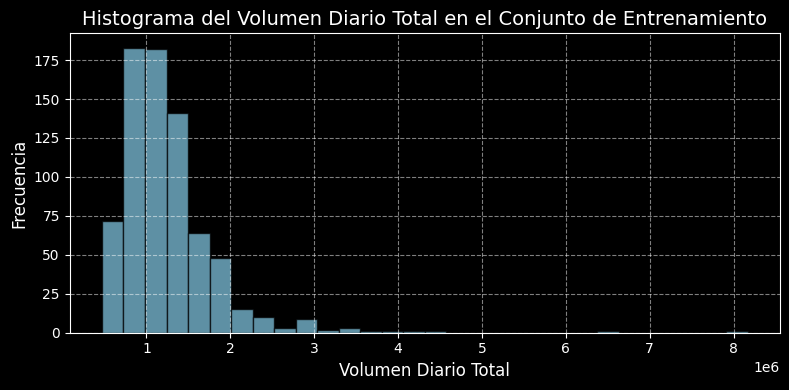

In [5]:
# Graficar el histograma del volumen diario total en el conjunto de entrenamiento
algo.plot_training_volume_histogram()

Calculate the average daily volume (ADV) as a mean and also as a median over daily volumes. How much do they differ? What are the advantages and disadvantages of using median vs mean to get an “average” estimation

In [6]:
# Calcular el volumen diario promedio (ADV) y discutir la diferencia entre media y mediana
algo.calculate_average_daily_volume()

Volumen Diario Promedio (Media): 1261181.74
Volumen Diario Promedio (Mediana): 1136875.00
Diferencia entre Media y Mediana: 124306.74

Ventajas de usar la Media:
- Captura todos los valores, incluyendo valores extremos.
- Es útil cuando los datos tienen una distribución simétrica.

Desventajas de usar la Media:
- Es sensible a valores atípicos (outliers), lo que puede distorsionar el promedio.

Ventajas de usar la Mediana:
- No se ve afectada por valores atípicos, lo que la hace más representativa en distribuciones asimétricas.
- Es más robusta cuando los datos tienen valores extremos.

Desventajas de usar la Mediana:
- No captura la magnitud de los valores extremos.
- Puede ser menos precisa si los valores están uniformemente distribuidos sin grandes outliers.


La media es útil cuando los datos están distribuidos de manera simétrica y no contienen muchos valores atípicos, pero puede ser engañosa si hay días con volúmenes muy extremos.
La mediana es una opción más robusta para estimar el volumen "típico" en casos donde la distribución es asimétrica o contiene valores extremos. Es menos susceptible a ser influenciada por outliers.

Separate the train set in days of the week (Mondays, Tuesdays… Fridays) and redo the analysis for each day of the week. Do you see any meaningful difference between these results and the global results? Do you see any pattern across days of the week?

Monday:
  Volumen Medio Diario (VAD) - Media: 1165484.28
  Volumen Medio Diario (VAD) - Mediana: 1043696.00

Tuesday:
  Volumen Medio Diario (VAD) - Media: 1197613.62
  Volumen Medio Diario (VAD) - Mediana: 1116151.00

Wednesday:
  Volumen Medio Diario (VAD) - Media: 1174438.82
  Volumen Medio Diario (VAD) - Mediana: 1089270.50

Thursday:
  Volumen Medio Diario (VAD) - Media: 1339089.11
  Volumen Medio Diario (VAD) - Mediana: 1194949.00

Friday:
  Volumen Medio Diario (VAD) - Media: 1433041.59
  Volumen Medio Diario (VAD) - Mediana: 1268933.00



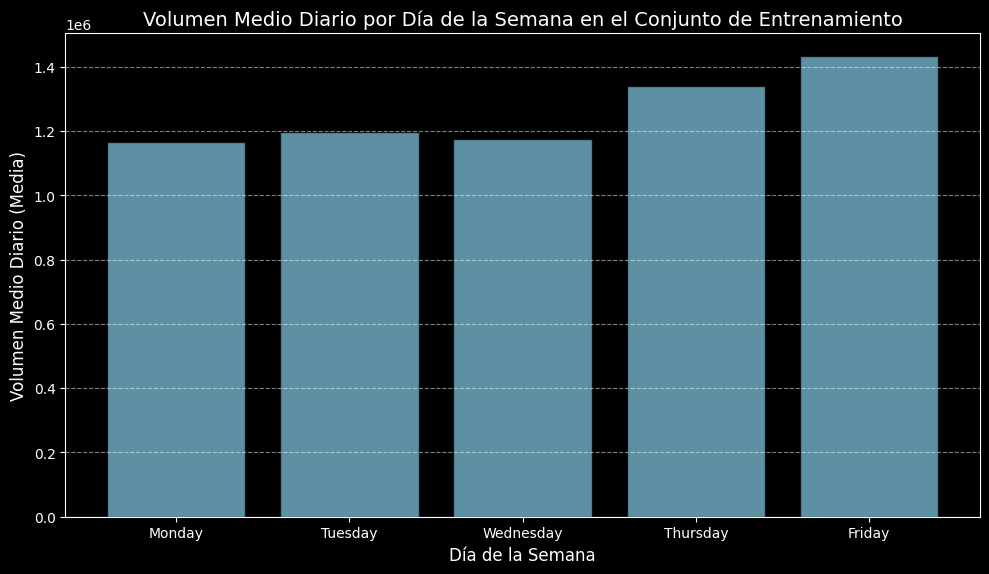

In [7]:
# Analizar los volúmenes por días de la semana
algo.analyze_days_of_week()


[Optional] Can you think about other kind of special days where a specific volume curve should be constructed? Which kind of volume profiles have these days?

In [8]:
# Días de anuncions de política monetarias y económicas
# Días de publicación de datos económicos clave (empleo, inflación, PIB)
# Vencimiento de contratos de futuros y opciones (conocido como "quadruple witching")
# Días de rebalanceo de índices (como el S&P 500)
# Días previos y posteriores a festivos

**Static volume prediction**

For each day (don’t differentiate here between days of the week) calculate the median of volumes for each interval of five minutes using the data from the same interval across days of the training set. You have to get a single median volume curve with as many points as five minute intervals in a day.

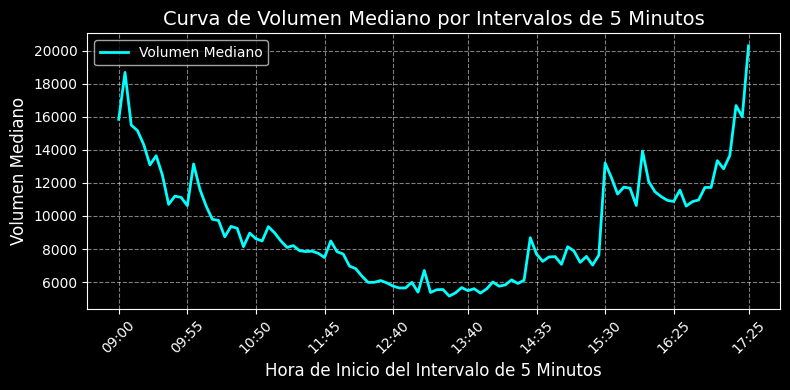

In [9]:
# Realizar la predicción estática del volumen
algo.static_volume_prediction()


Get the total volume of this curve, and generate a normalized volume curve by dividing each median volume per interval by the total volume. The resulting normalized curve has to sum to 1. This is a baseline static volume predictor. Plot the static curve. You should see the characteristic "U" shape of market volumes intraday, where most of the the trading happens at the beginning and the end of the trading session. Or more accurately, a "J" shape, with more trading activity at the end of the trading session.

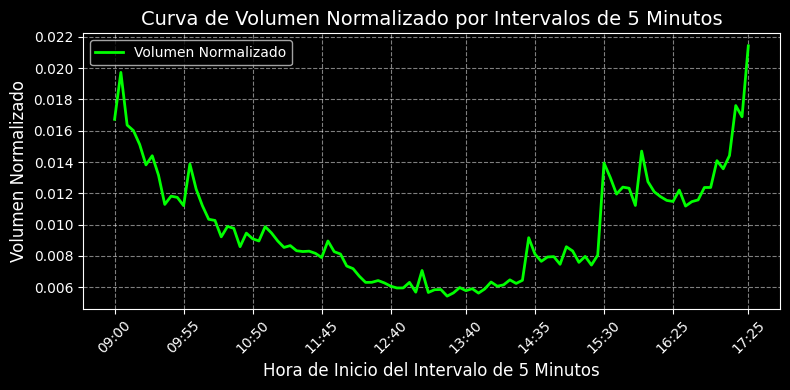

In [10]:
# Realizar la predicción de volumen normalizado
algo.normalized_volume_curve()

Repeat the same analysis but discriminating across days of the week so you get five different static volume curves, one per day of the week. You can also optionally consider other special days where you have detected particular volume profiles. Plot the static curves for each day of the week (and special days).

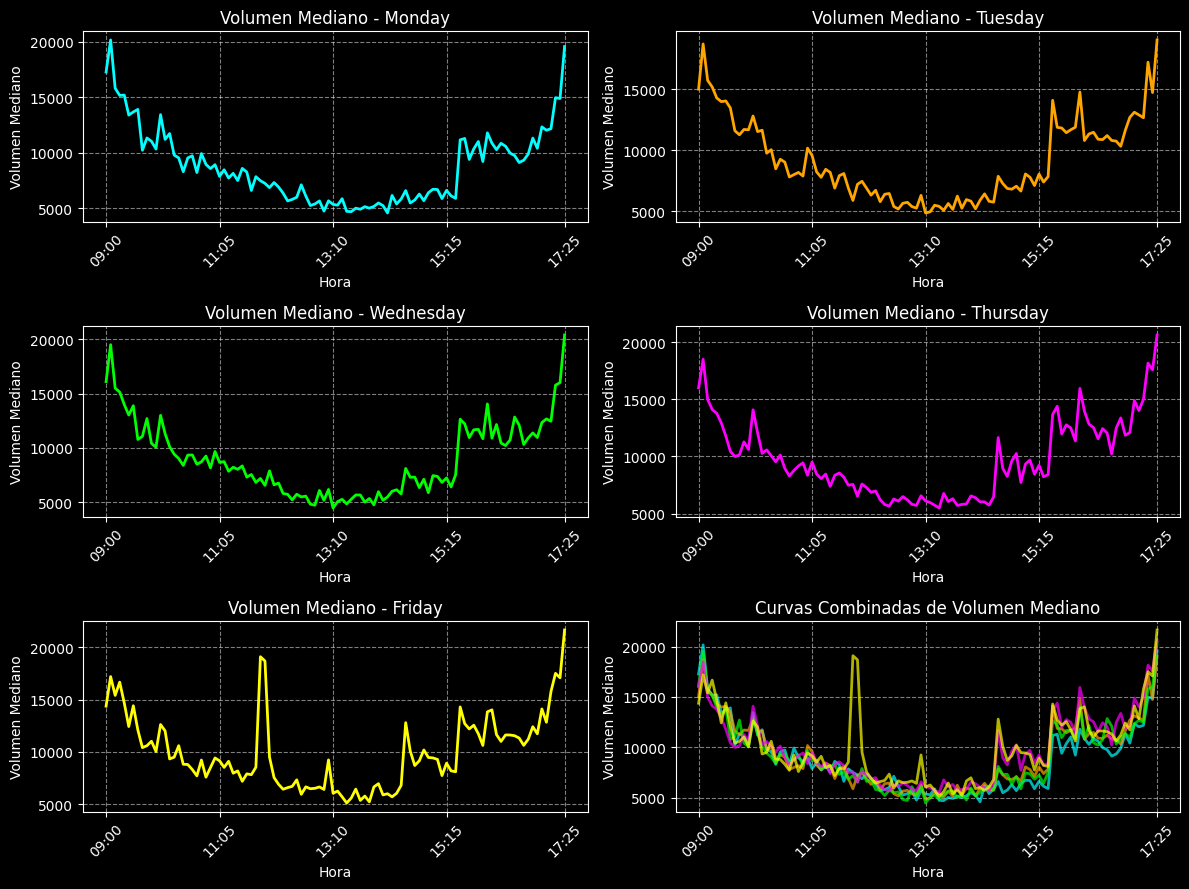

In [11]:
# Realizar la predicción de volumen estático discriminando por días de la semana
algo.static_volume_by_weekday()

Evaluate the quality of this baseline static volume predictor in the test set. For that, you need to normalize to one each of the daily volume profiles of the test set, and then compare the prediction for each 5 minute interval with the actual value. Use RMSE as the quality metric.

In [12]:
# Evaluar la calidad del predictor de volumen estático en el conjunto de prueba
algo.evaluate_static_volume_predictor()

RMSE Promedio del Predictor de Volumen Estático en el Conjunto de Prueba: 0.0066


This error as it is does not tell us much. We need to compare with some benchmark to make sense of it. Use as a benchmark a uniform prediction, i.e., the same percentage for each bin

In [13]:
# Evaluar la calidad del predictor de volumen uniforme en el conjunto de prueba
algo.evaluate_uniform_volume_predictor()

RMSE Promedio del Predictor Uniforme en el Conjunto de Prueba: 0.0076


Improve your prediction: instead of using a static separation train - test, using a moving average to compute the static curves. You can play with the length N of the window (before it was 3 years, maybe shorter works better?). In this case, for each day of the test set, 1) generate the static prediction using the N previous days, 2) compare this prediction with the actual normalized volume per bin that day and compute the mean square error of the prediction, 3) repeat for every day of the test set, 4) the final RMSE is the square root of the sum of mean square errors per day in the test set. Does the RMSE improve? To simplify the code, wrap it in the following class structure. You will also use it for the trading algorithm later

RMSE del predictor de volumen estático: 0.0074


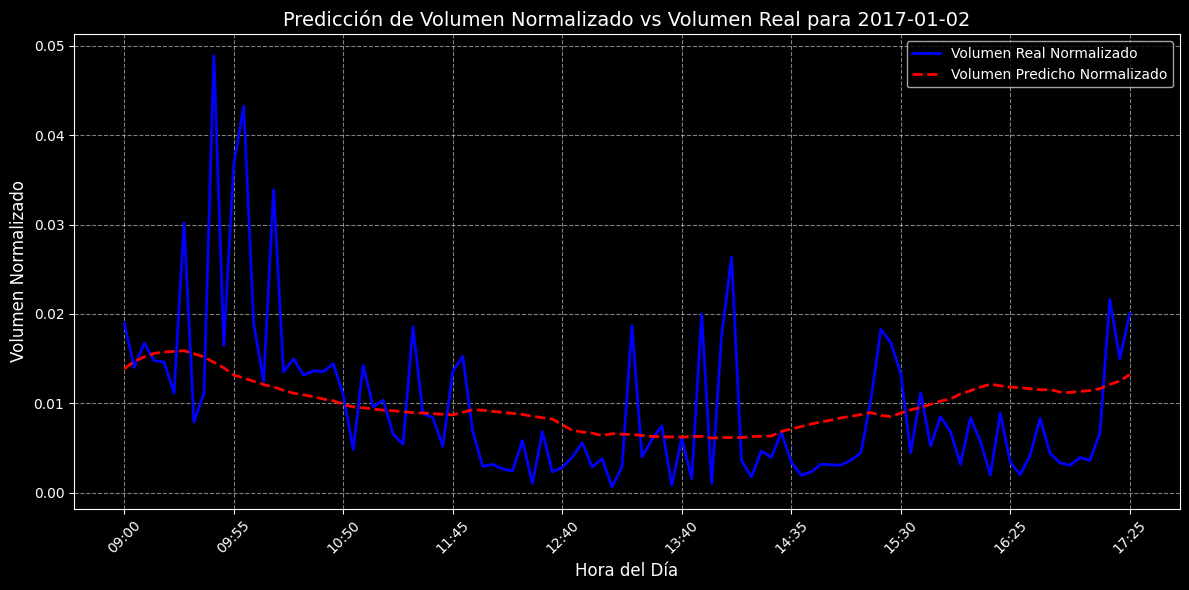

In [14]:
class StaticBinVolumePredictor:
    def __init__(self, window_size):
        """
        Clase para predecir la curva de volumen utilizando una media móvil para mejorar la separación de entrenamiento y prueba.

        Args:
            window_size (int): Tamaño de la ventana para calcular la media móvil.
        """
        self.window_size = window_size
        self.moving_avg_curve = None

    def train(self, train_df):
        """
        Entrenar el predictor utilizando los datos de volumen con una media móvil.

        Args:
            train_df (DataFrame): Datos de entrenamiento con las columnas ['date', 'time_5min', 'volume', 'vwap', 'day_of_week'].
        """
        # Calcular la media móvil para cada timestamp (promedio de volúmenes anteriores por ventana)
        self.moving_avg_curve = (
            train_df['volume']
            .rolling(window=self.window_size, min_periods=1)
            .mean()
            .groupby(train_df['time_5min'])
            .mean()
        )
        # Normalizar la curva de volumen
        self.moving_avg_curve /= self.moving_avg_curve.sum()

    def predict(self, day_times=None):
        """
        Predecir la curva de volumen estático para un día dado o para toda la serie.

        Args:
            day_times (Index, optional): Índices de tiempo del día a predecir. Si no se proporciona, se predice para todos los tiempos.

        Returns:
            Series: Predicción de la curva de volumen para el día o para toda la serie, con los índices correspondientes.
        """
        if day_times is None:
            return self.moving_avg_curve.fillna(0)
        else:
            return self.moving_avg_curve.reindex(day_times).fillna(0)

    def evaluate(self, test_df):
        """
        Evaluar el rendimiento del predictor comparando las predicciones con los valores reales normalizados.

        Args:
            test_df (DataFrame): Datos de prueba con las columnas ['date', 'time_5min', 'volume', 'vwap'].
        """
        mse_list = []
        unique_dates = test_df['date'].unique()
        for date in unique_dates:
            day_df = test_df[test_df['date'] == date]
            actual_curve = day_df.set_index('time_5min')['volume']
            actual_curve /= actual_curve.sum()  # Normalizar la curva de volumen real
            predicted_curve = self.predict(actual_curve.index)
            mse = mean_squared_error(actual_curve, predicted_curve)
            mse_list.append(mse)

        final_rmse = np.sqrt(np.mean(mse_list))
        print(f"RMSE del predictor de volumen estático: {final_rmse:.4f}")

    def visualize_prediction(self, test_df, date):
        """
        Visualizar la predicción frente a los valores reales normalizados para un día específico.

        Args:
            test_df (DataFrame): Datos de prueba con las columnas ['date', 'time_5min', 'volume', 'vwap'].
            date (str): Fecha específica para la cual se desea visualizar la predicción.
        """
        day_df = test_df[test_df['date'] == date]
        actual_curve = day_df.set_index('time_5min')['volume']
        actual_curve /= actual_curve.sum()  # Normalizar la curva de volumen real
        predicted_curve = self.predict(actual_curve.index)

        # Convertir los índices de tiempo a strings para etiquetar el eje x
        time_labels = actual_curve.index.astype(str).str[7:12]
        x_values = np.arange(len(time_labels))

        # Crear la figura
        plt.figure(figsize=(12, 6))

        # Graficar la curva de volumen real normalizado
        plt.plot(x_values, actual_curve.values, color='blue', linewidth=2, label='Volumen Real Normalizado')

        # Graficar la curva de volumen predicho normalizado
        plt.plot(x_values, predicted_curve.values, color='red', linewidth=2, linestyle='--', label='Volumen Predicho Normalizado')

        # Configuración del layout
        plt.title(f'Predicción de Volumen Normalizado vs Volumen Real para {date}', fontsize=14)
        plt.xlabel('Hora del Día', fontsize=12)
        plt.ylabel('Volumen Normalizado', fontsize=12)

        # Configurar los ticks del eje x
        num_ticks = 10
        ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
        labels = [time_labels[i] for i in ticks]
        plt.xticks(ticks=ticks, labels=labels, rotation=45)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejemplo de uso
# Asegúrate de importar pandas y tener los DataFrames 'algo.resampled_df' y 'algo.test_df' preparados
import pandas as pd

# Asumiendo que 'algo.resampled_df' y 'algo.test_df' ya están disponibles
volume_predictor = StaticBinVolumePredictor(window_size=10)  # Ajustar el hiperparámetro de la ventana

# Entrenar el predictor
volume_predictor.train(algo.train_df)

# Evaluar el rendimiento del predictor
volume_predictor.evaluate(algo.test_df)

# Visualizar la predicción para una fecha específica
volume_predictor.visualize_prediction(algo.test_df, '2017-01-02')


Try to improve your prediction using other predictive models. Bear in mind that the target is a normalized vector where all weights sum to one (i.e. akin to multi-class probability problem). Alternatively you can see the problem as a target percentage of volume by using at least one feature: the time bin

2024-11-14 10:48:49.130513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 10:48:52.699056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 10:48:52.699271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-14 10:48:53.513541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and y

NRMSE del predictor de volumen utilizando la RNN: 0.8642


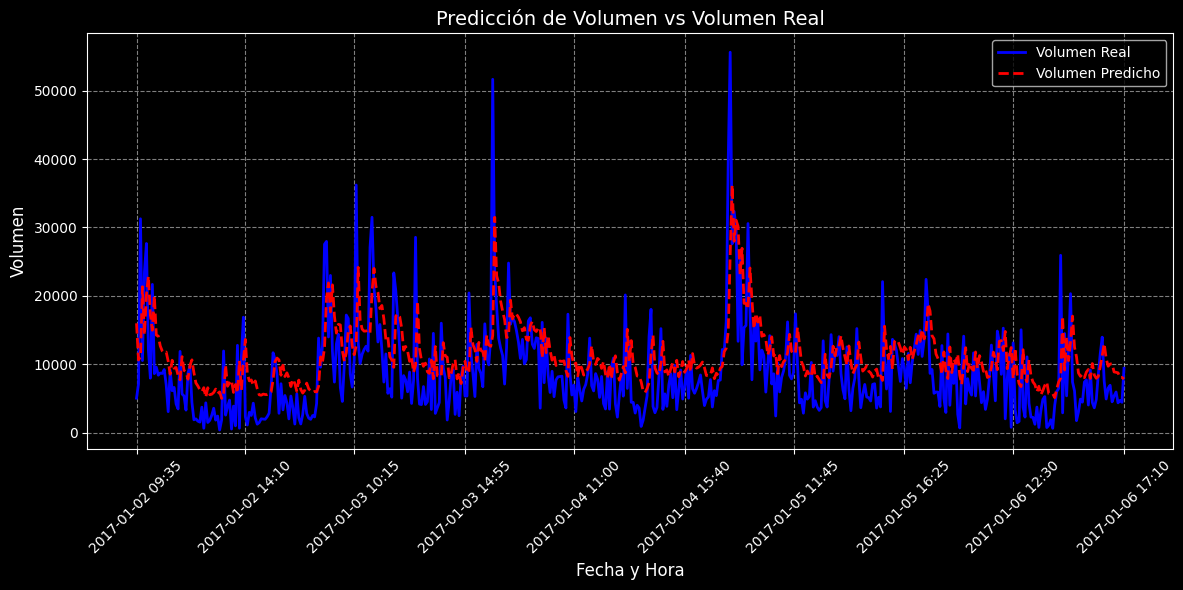

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Configuración para eliminar mensajes de advertencia e información
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '3' para suprimir advertencias e información
tf.get_logger().setLevel('ERROR')

# Configurar el estilo de matplotlib para modo oscuro
plt.style.use('dark_background')

class RNNVolumePredictor:
    def __init__(self, window_size=50, lstm_units=50, epochs=10, batch_size=64):
        """
        Clase para predecir la curva de volumen utilizando una RNN (LSTM) mejorada.

        Args:
            window_size (int): Tamaño de la ventana para los datos secuenciales.
            lstm_units (int): Número de unidades LSTM en la capa.
            epochs (int): Número de épocas para el entrenamiento.
            batch_size (int): Tamaño del batch para el entrenamiento.
        """
        self.window_size = window_size
        self.lstm_units = lstm_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.scaler = MinMaxScaler()

    def preprocess_data(self, df):
        """
        Preprocesar los datos para crear secuencias temporales.

        Args:
            df (DataFrame): Datos con las columnas ['date', 'time_5min', 'volume'].

        Returns:
            X (ndarray): Datos de entrada para el modelo.
            y (ndarray): Valores objetivo para el modelo.
        """
        # Asegurarse de que 'date' y 'time_5min' están en formato datetime y timedelta
        df['date'] = pd.to_datetime(df['date'])
        if not np.issubdtype(df['time_5min'].dtype, np.timedelta64):
            df['time_5min'] = pd.to_timedelta(df['time_5min'])
        # Ordenar los datos por fecha y hora
        df_sorted = df.sort_values(['date', 'time_5min'])
        # Crear una columna de timestamp combinando 'date' y 'time_5min'
        df_sorted['timestamp'] = df_sorted['date'] + df_sorted['time_5min']
        df_sorted.set_index('timestamp', inplace=True)
        volume = df_sorted['volume'].values.reshape(-1, 1)
        # Normalizar los datos
        volume_scaled = self.scaler.fit_transform(volume)

        X, y = [], []
        for i in range(self.window_size, len(volume_scaled)):
            X.append(volume_scaled[i - self.window_size:i])
            y.append(volume_scaled[i])

        X, y = np.array(X), np.array(y)
        return X, y

    def train(self, train_df):
        """
        Entrenar el predictor utilizando una RNN (LSTM).

        Args:
            train_df (DataFrame): Datos de entrenamiento con las columnas ['date', 'time_5min', 'volume'].
        """
        X_train, y_train = self.preprocess_data(train_df)

        # Crear el modelo LSTM
        self.model = Sequential()
        self.model.add(LSTM(units=self.lstm_units, input_shape=(X_train.shape[1], 1)))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

        # Entrenar el modelo
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, test_df):
        """
        Predecir la curva de volumen utilizando el modelo entrenado.

        Args:
            test_df (DataFrame): Datos de prueba con las columnas ['date', 'time_5min', 'volume'].

        Returns:
            ndarray: Predicciones escaladas a los valores originales.
        """
        # Asegurarse de que el modelo ha sido entrenado
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado aún.")

        # Preprocesar los datos de prueba
        df_sorted = test_df.sort_values(['date', 'time_5min'])
        df_sorted['timestamp'] = df_sorted['date'] + df_sorted['time_5min']
        df_sorted.set_index('timestamp', inplace=True)
        volume = df_sorted['volume'].values.reshape(-1, 1)
        volume_scaled = self.scaler.transform(volume)

        X_test = []
        for i in range(self.window_size, len(volume_scaled)):
            X_test.append(volume_scaled[i - self.window_size:i])

        X_test = np.array(X_test)
        # Hacer predicciones
        predictions_scaled = self.model.predict(X_test, verbose=0)
        # Desescalar las predicciones
        predictions = self.scaler.inverse_transform(predictions_scaled)
        return predictions.flatten()

    def evaluate(self, test_df):
        """
        Evaluar el rendimiento del predictor comparando las predicciones con los valores reales.

        Args:
            test_df (DataFrame): Datos de prueba con las columnas ['date', 'time_5min', 'volume'].

        Returns:
            float: NRMSE (Error Cuadrático Medio Normalizado) de la predicción.
        """
        df_sorted = test_df.sort_values(['date', 'time_5min'])
        volume_real = df_sorted['volume'].values[self.window_size:]

        predictions = self.predict(test_df)

        mse = mean_squared_error(volume_real, predictions)
        rmse = np.sqrt(mse)
        std_real = np.std(volume_real)
        nrmse = rmse / std_real
        print(f"NRMSE del predictor de volumen utilizando la RNN: {nrmse:.4f}")
        return nrmse

    def visualize_prediction(self, test_df, start_index=0, num_points=500):
        """
        Visualizar las predicciones frente a los valores reales.

        Args:
            test_df (DataFrame): Datos de prueba con las columnas ['date', 'time_5min', 'volume'].
            start_index (int): Índice inicial para la visualización.
            num_points (int): Número de puntos a visualizar.
        """
        df_sorted = test_df.sort_values(['date', 'time_5min'])
        df_sorted['timestamp'] = df_sorted['date'] + df_sorted['time_5min']
        df_sorted.set_index('timestamp', inplace=True)
        volume_real = df_sorted['volume'].values[self.window_size:]
        predictions = self.predict(test_df)

        # Seleccionar el rango para visualizar
        end_index = start_index + num_points
        volume_real = volume_real[start_index:end_index]
        predictions = predictions[start_index:end_index]
        timestamps = df_sorted.index[self.window_size + start_index:self.window_size + end_index]

        # Convertir los timestamps a strings para las etiquetas del eje x
        time_labels = timestamps.strftime('%Y-%m-%d %H:%M')
        x_values = np.arange(len(time_labels))

        # Crear la figura usando matplotlib
        plt.figure(figsize=(12, 6))

        # Graficar la curva de volumen real
        plt.plot(x_values, volume_real, color='blue', linewidth=2, label='Volumen Real')

        # Graficar la curva de volumen predicho
        plt.plot(x_values, predictions, color='red', linewidth=2, linestyle='--', label='Volumen Predicho')

        # Configuración del layout
        plt.title('Predicción de Volumen vs Volumen Real', fontsize=14)
        plt.xlabel('Fecha y Hora', fontsize=12)
        plt.ylabel('Volumen', fontsize=12)

        # Configurar los ticks del eje x
        num_ticks = 10
        ticks = np.linspace(0, len(x_values)-1, num_ticks, dtype=int)
        labels = [time_labels[i] for i in ticks]
        plt.xticks(ticks=ticks, labels=labels, rotation=45)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejemplo de uso

# Crear una instancia del predictor
volume_predictor = RNNVolumePredictor(window_size=7, lstm_units=50, epochs=10, batch_size=32)  # Ajustar hiperparámetros para mayor estabilidad

# Entrenar el predictor
volume_predictor.train(algo.train_df)

# Evaluar el rendimiento del predictor
nrmse = volume_predictor.evaluate(algo.test_df)

# Visualizar la predicción
volume_predictor.visualize_prediction(algo.test_df, start_index=0, num_points=500)


**Dynamic volume predictor**

The static volume predictor developed so far does not use the current intraday information to update predictions. This can be a weakness if we observe intraday volume patterns that differ from the historical ones, since the model cannot adapt to them. You will implement a K-nearest neighbours model for dynamic prediction with the following logic:
* The training of the model is simple, we just store all the days of the training set which contain volumes per bin intraday
* For prediction, given the current day with n bins already known, we calculate the Euclidean distance with respect to every curve in the training set (truncated of course to have the same number of bins). We sort the results by this distance and select the K nearest.
* The prediction will be then the median of volume in the next bin using those K nearest neighbours. You will also predict in this model the volume until the end of the day.
* You need to decide how to handle the initilization, when you don't have data from the intraday (or even when you just have a few bins) as to calculate the nearest neighbours.
* The output will be a tuple with the prediction for next bin, and the prediction until the end of the day

I recommend to implement this from scratch in code, but is up to you if you want to adapt any existing implementation of KNN like the one in sklearn.

Wrap your model also in a class structure:

          date   vwap_algo  vwap_market
0   2017-01-02  156.979715   156.856686
1   2017-01-03  159.366235   159.190686
2   2017-01-04  160.371809   160.329800
3   2017-01-05  160.923692   160.868180
4   2017-01-06  160.562283   160.546158
..         ...         ...          ...
238 2017-12-19  200.447950   200.406543
239 2017-12-20  197.998050   197.522090
240 2017-12-21  195.253610   195.313176
241 2017-12-22  195.210285   195.249884
242 2017-12-28  194.166354   194.027319

[243 rows x 3 columns]
MAE entre vwap_algo y vwap_market: 0.08208068823802087


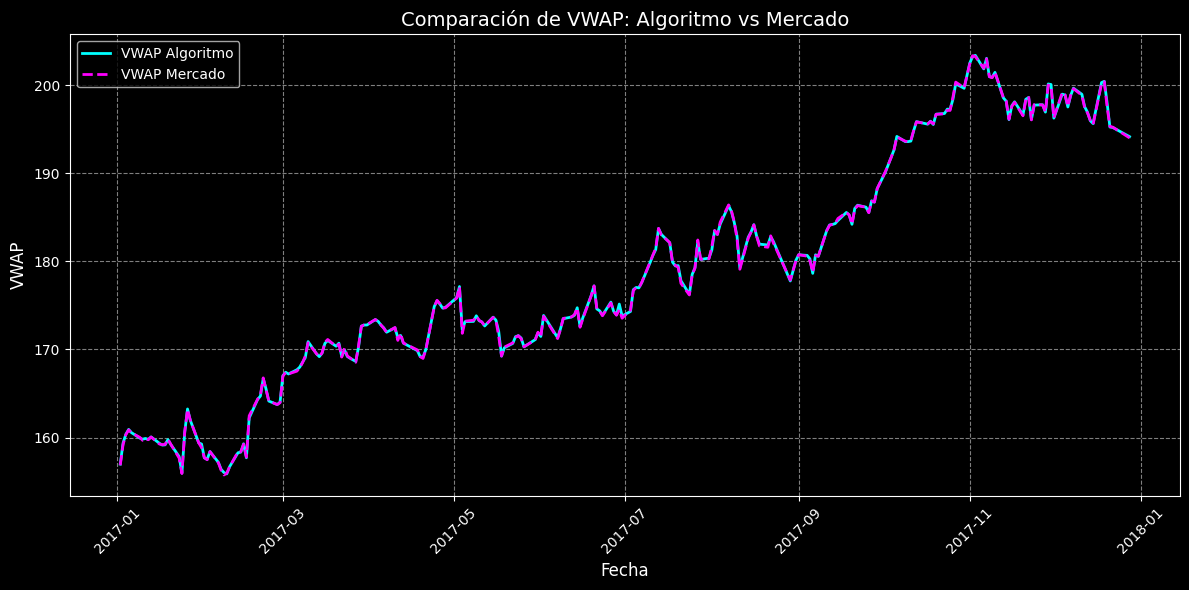

In [16]:
from sklearn.metrics import euclidean_distances, mean_squared_error, mean_absolute_error


class dynamicVolumePredictor:
    def __init__(self, k=5):
        """
        Clase para predecir la curva de volumen utilizando un modelo K-Nearest Neighbours (KNN) para predicciones dinámicas.

        Args:
            k (int): Número de vecinos cercanos a considerar para la predicción.
        """
        self.k = k
        self.historical_data = None  # Para almacenar los datos históricos

    def train(self, historical_df):
        """
        Entrenar el modelo almacenando los datos históricos.

        Args:
            historical_df (DataFrame): Datos históricos con columnas ['date', 'time_5min', 'volume'].
        """
        # Almacenar las curvas de volumen diarias para entrenamiento
        self.historical_data = historical_df.pivot(index='date', columns='time_5min', values='volume')

    def predict(self, intraday_df):
        """
        Predecir el volumen para el siguiente intervalo de tiempo y hasta el final del día.

        Args:
            intraday_df (DataFrame): Datos intradía conocidos con columnas ['date', 'time_5min', 'volume'].

        Returns:
            tuple: Predicción del siguiente intervalo y predicción hasta el final del día.
        """
        if self.historical_data is None:
            raise ValueError("El modelo no ha sido entrenado aún con datos históricos.")

        # Obtener la curva parcial del día actual
        current_day = intraday_df['date'].iloc[0]
        current_curve = intraday_df.pivot(index='date', columns='time_5min', values='volume').iloc[0]
        current_curve = current_curve.dropna()  # Eliminar valores no conocidos
        n_bins = len(current_curve)

        # Caso de inicialización: si no hay suficientes datos intradía, usar promedio histórico
        if n_bins == 0:
            avg_volume = self.historical_data.mean(axis=0)
            next_bin_prediction = avg_volume.iloc[0]
            full_day_prediction = avg_volume.sum()
            return next_bin_prediction, full_day_prediction

        # Calcular la distancia euclidiana entre la curva parcial actual y las curvas históricas
        historical_truncated = self.historical_data.iloc[:, :n_bins].dropna()
        distances = euclidean_distances([current_curve], historical_truncated.values)[0]

        # Encontrar los K vecinos más cercanos
        nearest_indices = np.argsort(distances)[:self.k]
        nearest_curves = self.historical_data.iloc[nearest_indices]

        # Predicción para el siguiente intervalo
        next_bin_volumes = nearest_curves.iloc[:, n_bins]
        next_bin_prediction = np.median(next_bin_volumes)

        # Predicción para el resto del día
        remaining_volumes = nearest_curves.iloc[:, n_bins:].sum(axis=1)
        full_day_prediction = np.median(remaining_volumes)

        return next_bin_prediction, full_day_prediction

    def evaluate(self, test_df):
        """
        Evaluar el rendimiento del predictor utilizando datos de prueba.

        Args:
            test_df (DataFrame): Datos de prueba con columnas ['date', 'time_5min', 'volume'].

        Returns:
            dict: Métricas de rendimiento (RMSE, MAE).
        """
        dates = test_df['date'].unique()
        predictions = []
        actuals = []

        for date in dates:
            intraday_df = test_df[test_df['date'] == date].iloc[:10]  # Tomar los primeros 10 registros del día actual
            next_bin_prediction, _ = self.predict(intraday_df)
            actual_volume = test_df[(test_df['date'] == date) & (test_df['time_5min'] == intraday_df['time_5min'].iloc[-1])]['volume'].values[0]
            predictions.append(next_bin_prediction)
            actuals.append(actual_volume)

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)

        return {'RMSE': rmse, 'MAE': mae}

class Order:
    def __init__(self, side, volume):
        self.side = side
        self.volume = volume

class OrderManager:
    def __init__(self):
        self.orders = []

    def submitOrder(self, side, volume):
        order = Order(side, volume)
        self.orders.append(order)

class BacktestingSession:
    def run_backtest(self, historical_df, trading_algo, start_date, end_date=None):
        backtesting_result = []
        full_test_df = historical_df[historical_df["date"] >= start_date]
        if end_date is not None:
            full_test_df = full_test_df[full_test_df["date"] <= end_date]
        test_dates = np.unique(full_test_df["date"])
        # Ejecutar backtest para cada fecha entre start_date y end_date
        for date in test_dates:
            # Entrenar algoritmo de trading antes de que abra el mercado con datos históricos
            train_df = historical_df[historical_df["date"] < date]
            trading_algo.beforeMarketOpen(train_df)
            # Iniciar la sesión de mercado. Desplazamos el dataframe para pasar al algoritmo info sobre el bin anterior en el tiempo actual
            test_df = historical_df[historical_df["date"] == date]
            shifted_test_df = test_df.set_index("time_5min").shift(1).reset_index()
            vwap_algo = 0
            volume_algo = 0
            for bin_time in shifted_test_df["time_5min"]:
                # Llamar a onDataEvent y pasar la información del mercado actual
                order_manager = trading_algo.onDataEvent(shifted_test_df[shifted_test_df["time_5min"] == bin_time])
                vwap_next_bin = float(test_df[test_df["time_5min"] == bin_time]["vwap"].iloc[0])
                total_volume_bin = 0
                for order in order_manager.orders:
                    total_volume_bin += order.volume * order.side
                volume_algo += np.abs(total_volume_bin)
                vwap_algo += total_volume_bin * vwap_next_bin
            # Calcular el VWAP del algoritmo y del mercado
            vwap_algo = vwap_algo / volume_algo if volume_algo != 0 else 0
            vwap_market = (test_df["volume"] * test_df["vwap"]).sum() / test_df["volume"].sum()
            backtesting_result.append({"date": date, "vwap_algo": vwap_algo, "vwap_market": vwap_market})
        return pd.DataFrame(backtesting_result)

# Ejemplo de uso
# Crear instancia del predictor
dynamic_predictor = dynamicVolumePredictor(k=5)

# Asumiendo que 'algo.resampled_df' tiene las columnas ['date', 'time_5min', 'volume', 'vwap']

# Dividir los datos en entrenamiento y prueba
train_df = algo.resampled_df[algo.resampled_df['date'] < '2017-01-01']
test_df = algo.resampled_df[algo.resampled_df['date'] >= '2017-01-01']

# Entrenar el predictor
dynamic_predictor.train(train_df)

# Evaluar el rendimiento del predictor con los datos de prueba
evaluation_metrics = dynamic_predictor.evaluate(test_df)
# print(f"Métricas de evaluación del modelo dinámico: {evaluation_metrics}")

# Crear una clase de algoritmo de trading que use el predictor dinámico
class TradingAlgorithm:
    def __init__(self, predictor):
        self.predictor = predictor
        self.order_manager = OrderManager()

    def beforeMarketOpen(self, historical_data):
        # Entrenar el predictor antes de que abra el mercado
        self.predictor.train(historical_data)

    def onDataEvent(self, intraday_data):
        # Predecir el siguiente volumen
        next_bin_prediction, _ = self.predictor.predict(intraday_data)
        # Crear una orden basada en la predicción
        side = 1  # Asumimos lado de compra (1) para simplicidad
        volume = next_bin_prediction
        self.order_manager.submitOrder(side, volume)
        return self.order_manager

# Crear instancia del algoritmo de trading
trading_algo = TradingAlgorithm(dynamic_predictor)

# Crear una sesión de backtesting
backtesting_session = BacktestingSession()

# Ejecutar el backtesting
backtesting_result = backtesting_session.run_backtest(algo.resampled_df, trading_algo, start_date='2017-01-01', end_date='2017-12-31')

# Mostrar los resultados del backtesting
print(backtesting_result)

# Calcular el MAE entre vwap_algo y vwap_market
mae_vwap = mean_absolute_error(backtesting_result['vwap_market'], backtesting_result['vwap_algo'])
print(f"MAE entre vwap_algo y vwap_market: {mae_vwap}")

# Crear la figura usando matplotlib
plt.figure(figsize=(12, 6))

# Graficar la curva de VWAP del algoritmo
plt.plot(backtesting_result['date'], backtesting_result['vwap_algo'], color='cyan', linewidth=2, label='VWAP Algoritmo')

# Graficar la curva de VWAP del mercado
plt.plot(backtesting_result['date'], backtesting_result['vwap_market'], color='magenta', linewidth=2, linestyle='--', label='VWAP Mercado')

# Configuración del layout
plt.title('Comparación de VWAP: Algoritmo vs Mercado', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('VWAP', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



Train your model with training data and evaluate the quality with test data. Compare the metrics with respect to the static model. You should not only consider average predictive quality, also the variance. Also compare the result against baselines, for instance the previous bin volume as a prediction for the next bin, or the previous day total volume (substracting the current executed volume) for the total volume prediction.

[Optional] Try to improve your prediction using other predictive models

**Backtesting environment**

The following code is a simple backtesting environment to run your execution algorithm. Feel free to analyse the code but do not change the implementation

In [17]:
class Order:
    def __init__(self, side, volume):
        self.side = side
        self.volume = volume

class OrderManager():
    def __init__(self):
        self.orders = []

    def submitOrder(self, side, volume):
        order = Order(side, volume)
        self.orders.append(order)

class BacktestingSession:
    def run_backtest(self, historical_df, trading_algo, start_date, end_date = None):
        backtesting_result = pd.DataFrame(columns = ["date", "vwap_algo", "vwap_market"])
        full_test_df = historical_df[historical_df["date"] >= start_date]
        if not end_date is None:
            full_test_df = full_test_df[full_test_df["date"]<= end_date]
        test_dates = np.unique(full_test_df["date"])
        # Run backtest for each date between start_date and end_date (if none until last date in historical_df)
        for date in test_dates:
            # Train trading algorithm before the market opens with historical data
            train_df = historical_df[historical_df["date"] < date]
            trading_algo.beforeMarketOpen(train_df)
            # Now start the market session. We shift the dataframe to pass the algo info about previous bin at current time
            test_df = historical_df[historical_df["date"] == date]
            shifted_test_df = test_df.set_index("time").shift(1).reset_index()
            vwap_algo = 0
            volume_algo = 0
            for bin_time in shifted_test_df["time"]:
                # Call onDataEvent and pass the current market information: time (start of next bin), previous volume and vwap
                # It returns order manager object with orders submitted by algo
                order_manager = myalgo.onDataEvent(shifted_test_df[shifted_test_df["time"] == bin_time])
                vwap_next_bin = float(test_df[test_df["time"] == bin_time]["vwap"])
                total_volume_bin = 0
                for order in order_manager.orders:
                    # we consider potentially several orders, but since we assume all execute at vwap we just net them
                    # if they have different signs
                    total_volume_bin += order.volume * order.side
                volume_algo += np.abs(total_volume_bin)
                vwap_algo += total_volume_bin * vwap_next_bin
            # Calculate the vwap from the algo by normalizing by price executed by volume and calculate market vwap
            vwap_algo = vwap_algo / volume_algo
            vwap_market = (test_df["volume"] * test_df["vwap"]).sum() / test_df["volume"].sum()
            backtesting_result = backtesting_result.append({"date": date, "vwap_algo": vwap_algo, "vwap_market": vwap_market}, ignore_index = True)
        return backtesting_result

**Static VWAP execution algorithm**

Implement a class for a static VWAP execution algorithm with the following structure:
Inputs:
* Amount of shares to execute (Q). Use a check to avoid that the user inputs more than 25% of the ADV calculated above to prevent a huge market impact
* Side of the order: +1 for buy and -1 for sell
* Start time / end time: for this exercise, we will consider that starts at 9:00 and ends at 17:30. We can relax this assumption but then you need to renormalize the static volume curve to the period
* Hyperparameters for the volume predictor, if needed

The logic of the algorithm is the following: every time a time bin of 5 minutes ends, it sends an order to our execution management system (EMS) with a volume given by the static volume predictor:

$q_i = Q E[\frac{v_i}{V}]$

where the term $E[\frac{v_i}{V}]$ is your static volume prediction for the given time bin. The method beforeMarketOpen gets a dataframe with columns: date, time, volume, vwap, day_of_week containing historical volumes and prices per bin in previous days. The method onDataEvent has as input a market data object containing the current time, the executed market volume and VWAP price of the previous bin (e.g. at 9:05:00 reports volume and vwap of bin 9:00:00 - 0:05:00).  It will return a order manager object containing the parent order volume. Our simulation environment will assume that the EMS is able to execute at VWAP price within the next bin the order submitted.

In [18]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Definir las clases Order y OrderManager
class Order:
    def __init__(self, side, volume):
        self.side = side
        self.volume = volume

class OrderManager:
    def __init__(self):
        self.orders = []
    
    def submitOrder(self, side, volume):
        order = Order(side, volume)
        self.orders.append(order)

# Definir la clase static_vwap_algorithm
class static_vwap_algorithm:
    def __init__(self, Q, side, start_time='09:00:00', end_time='17:30:00', adv=None):
        self.Q = Q
        self.side = side
        self.start_time = pd.to_timedelta(start_time)
        self.end_time = pd.to_timedelta(end_time)
        self.static_volume_profile = None
        self.current_bin = 0
        self.time_bins = None
        self.adv = adv

        if self.side not in [-1, 1]:
            raise ValueError("El lado de la orden debe ser +1 (compra) o -1 (venta).")

    def beforeMarketOpen(self, historical_df):
        mask = (historical_df['time_5min'] >= self.start_time) & (historical_df['time_5min'] <= self.end_time)
        trading_hours_df = historical_df[mask]

        if self.adv is None:
            daily_volumes = trading_hours_df.groupby('date')['volume'].sum()
            self.adv = daily_volumes.mean()

        if self.Q > 0.25 * self.adv:
            raise ValueError(f"La cantidad de acciones Q ({self.Q}) excede el 25% del ADV ({self.adv}).")

        volume_profile = trading_hours_df.groupby('time_5min')['volume'].median()
        total_volume = volume_profile.sum()
        self.static_volume_profile = volume_profile / total_volume

        self.time_bins = sorted(self.static_volume_profile.index.unique())
        self.total_bins = len(self.time_bins)
        self.current_bin = 0

    def onDataEvent(self, market_data):
        if self.current_bin >= self.total_bins:
            return OrderManager()

        current_time = self.time_bins[self.current_bin]
        volume_fraction = self.static_volume_profile[current_time]
        q_i = self.Q * volume_fraction

        # Crear una nueva instancia de OrderManager para esta orden
        order_manager = OrderManager()
        order_manager.submitOrder(self.side, q_i)

        self.current_bin += 1

        return order_manager

# Definir la clase BacktestingSession con correcciones
class BacktestingSession:
    def run_backtest(self, historical_df, trading_algo, start_date, end_date=None):
        backtesting_result = []
        full_test_df = historical_df[historical_df["date"] >= start_date]
        if end_date is not None:
            full_test_df = full_test_df[full_test_df["date"] <= end_date]
        test_dates = np.unique(full_test_df["date"])

        side = trading_algo.side  # Obtener el lado de la orden

        for date in test_dates:
            train_df = historical_df[historical_df["date"] < date]
            trading_algo.beforeMarketOpen(train_df)

            test_df = historical_df[historical_df["date"] == date]
            shifted_test_df = test_df.set_index("time_5min").shift(1).reset_index()
            vwap_algo = 0
            volume_algo = 0
            for bin_time in shifted_test_df["time_5min"]:
                order_manager = trading_algo.onDataEvent(shifted_test_df[shifted_test_df["time_5min"] == bin_time])
                if test_df[test_df["time_5min"] == bin_time].empty:
                    continue
                vwap_next_bin = float(test_df[test_df["time_5min"] == bin_time]["vwap"].iloc[0])
                total_volume_bin = 0
                for order in order_manager.orders:
                    total_volume_bin += np.abs(order.volume)
                volume_algo += total_volume_bin
                vwap_algo += total_volume_bin * vwap_next_bin
            vwap_algo = vwap_algo / volume_algo if volume_algo != 0 else 0
            vwap_market = (test_df["volume"] * test_df["vwap"]).sum() / test_df["volume"].sum()
            # Calcular el error porcentual ajustado según el lado de la orden
            if side == 1:
                pcterror_vwap_bps = 10000 * (vwap_algo - vwap_market) / vwap_market
            else:
                pcterror_vwap_bps = 10000 * (vwap_market - vwap_algo) / vwap_market
            backtesting_result.append({
                "date": date,
                "vwap_algo": vwap_algo,
                "vwap_market": vwap_market,
                "pcterror_vwap_bps": pcterror_vwap_bps
            })
        return pd.DataFrame(backtesting_result)


Now run your execution algorithm over the test set to generate the performance metrics, in our case we will perform daily executions. The backtesting environment returns a dataframe with the VWAP of each execution as well as the market VWAP. Analyse the result:
* For each day of the test set, calculate the percentage error between the trading algorithm VWAP and the market VWAP in basis points:

${\rm pcterror_{vwap}}(bps) = 10000 * \frac{VWAP_{algo} - VWAP_{market}}{VWAP_{market}}$

* Calculate the statistics of this differences in bps over the test set:
    * Histogram of the differences
    * Mean and standard deviation
    * Percentile 1, 5, 95 and 99
* Have a look at the best and worst performance cases, why do you think the algorithm performs so bad/well in these days?
* Compare a buy order versus a sell order, is there any difference in the performance? Would you expect one given the way the trading algorithm is built?
* Imagine you are running a broker-dealer business where you execute orders on behalf of clients. You are going to do this business regularly for buy orders. You guarantee the client the market VWAP for the execution but they have to pay you a fee. You would like to use the histogram from the back-testing to find a fee that on average makes you win money from this business, what would be?

Resultados para Compra:
Error Medio Compra (bps): 1.46
Desviación Estándar del Error Compra (bps): 6.04
Percentiles Compra:
Percentil 1%: -12.33 bps
Percentil 5%: -7.01 bps
Percentil 95%: 13.69 bps
Percentil 99%: 22.98 bps

Resultados para Venta:
Error Medio Venta (bps): -1.46
Desviación Estándar del Error Venta (bps): 6.04
Percentiles Venta:
Percentil 1%: -22.98 bps
Percentil 5%: -13.69 bps
Percentil 95%: 7.01 bps
Percentil 99%: 12.33 bps

Comparación entre Compra y Venta:
Error Medio Compra (bps): 1.46
Error Medio Venta  (bps): -1.46


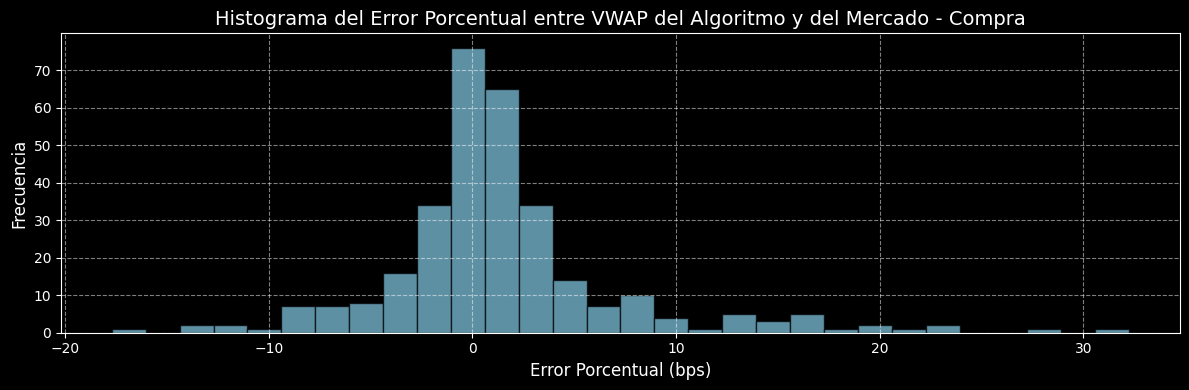

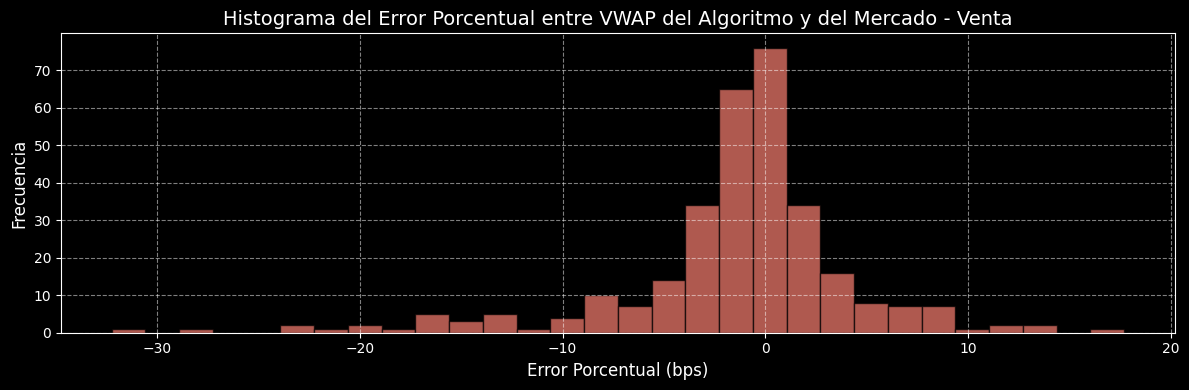


Mejores Casos - Compra:
          date  pcterror_vwap_bps
145 2017-08-01         -17.706363
221 2017-11-24         -13.674672
54  2017-03-17         -12.812629
174 2017-09-15         -12.357635
201 2017-10-26         -12.083119

Peores Casos - Compra:
          date  pcterror_vwap_bps
239 2017-12-20          21.267595
268 2018-02-06          23.151884
94  2017-05-17          23.926425
122 2017-06-29          27.697804
293 2018-03-13          32.253299

Mejores Casos - Venta:
          date  pcterror_vwap_bps
293 2018-03-13         -32.253299
122 2017-06-29         -27.697804
94  2017-05-17         -23.926425
268 2018-02-06         -23.151884
239 2017-12-20         -21.267595

Peores Casos - Venta:
          date  pcterror_vwap_bps
201 2017-10-26          12.083119
174 2017-09-15          12.357635
54  2017-03-17          12.812629
221 2017-11-24          13.674672
145 2017-08-01          17.706363

Tarifa mínima recomendada para Compra (bps): 2.46
Tarifa mínima recomendada para Venta 

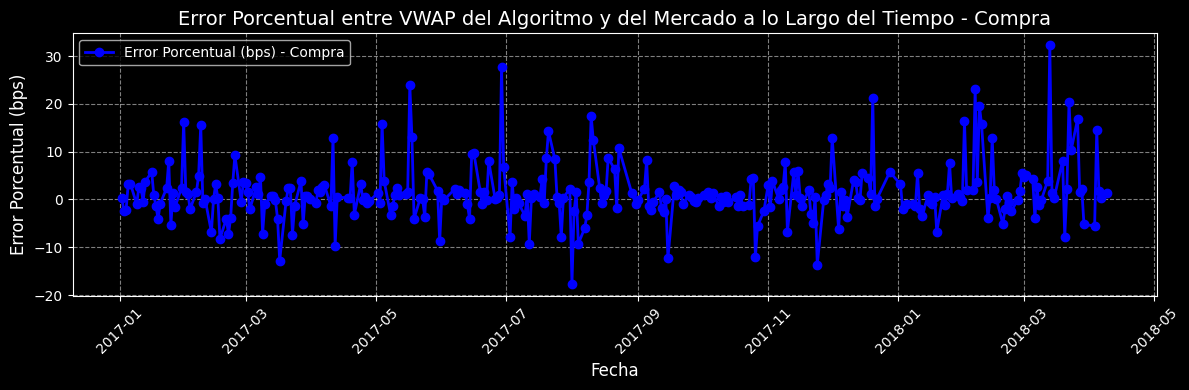

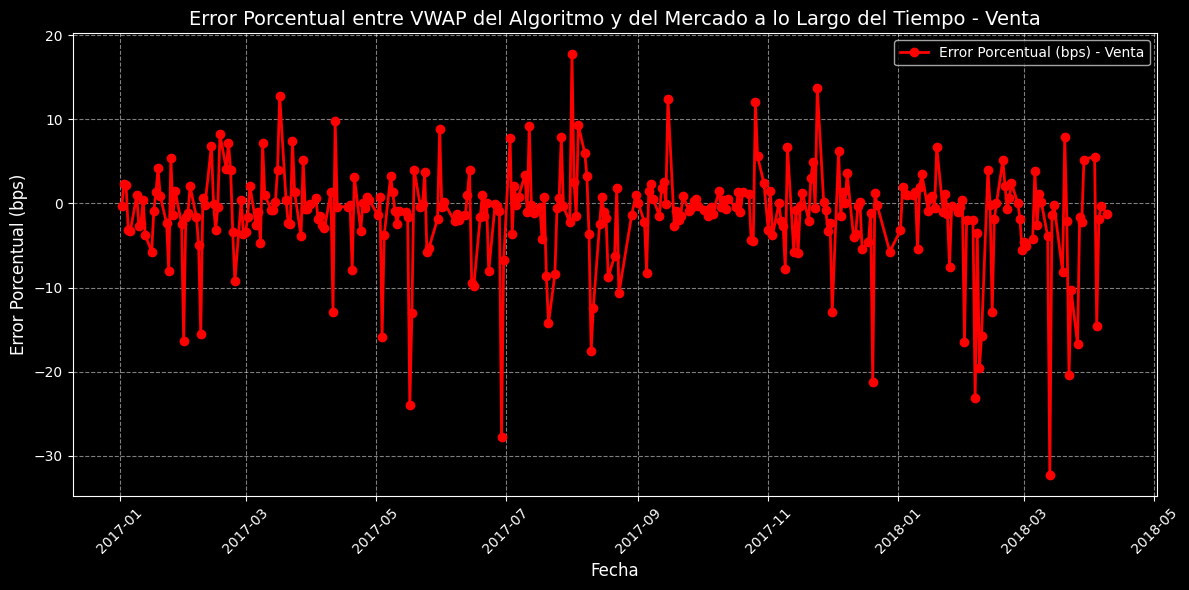

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configurar el estilo de matplotlib para modo oscuro
plt.style.use('dark_background')

# Suponiendo que ya tienes 'algo.resampled_df' con las columnas ['date', 'time_5min', 'volume', 'vwap']
# Si no, asegúrate de cargar y preparar los datos adecuadamente.

# Dividir los datos en entrenamiento y prueba
train_df = algo.resampled_df[algo.resampled_df['date'] < '2017-01-01']
test_df = algo.resampled_df[algo.resampled_df['date'] >= '2017-01-01']

# Definir los parámetros
Q = 0.25 * train_df.groupby('date')['volume'].sum().mean()  # 25% del ADV calculado

# Crear una instancia del algoritmo de ejecución VWAP estático para compra
side_buy = 1  # +1 para compra
myalgo_buy = static_vwap_algorithm(Q=Q, side=side_buy)

# Crear una sesión de backtesting
backtesting = BacktestingSession()

# Ejecutar el backtesting para compra
backtest_results_buy = backtesting.run_backtest(algo.resampled_df, myalgo_buy, start_date='2017-01-02')

# Calcular el porcentaje de error en basis points (bps) para compra
backtest_results_buy['pcterror_vwap_bps'] = 10000 * (backtest_results_buy['vwap_algo'] - backtest_results_buy['vwap_market']) / backtest_results_buy['vwap_market']

# Calcular estadísticas para compra
mean_error_buy = backtest_results_buy['pcterror_vwap_bps'].mean()
std_error_buy = backtest_results_buy['pcterror_vwap_bps'].std()
percentiles_buy = backtest_results_buy['pcterror_vwap_bps'].quantile([0.01, 0.05, 0.95, 0.99])

# Mostrar resultados para compra
print("Resultados para Compra:")
print(f"Error Medio Compra (bps): {mean_error_buy:.2f}")
print(f"Desviación Estándar del Error Compra (bps): {std_error_buy:.2f}")
print("Percentiles Compra:")
for percentile, value in percentiles_buy.items():
    print(f"Percentil {int(percentile*100)}%: {value:.2f} bps")

# Crear una instancia del algoritmo de ejecución VWAP estático para venta
side_sell = -1  # -1 para venta
myalgo_sell = static_vwap_algorithm(Q=Q, side=side_sell)

# Ejecutar el backtesting para venta
backtest_results_sell = backtesting.run_backtest(algo.resampled_df, myalgo_sell, start_date='2017-01-02')

# Calcular el porcentaje de error en basis points (bps) para venta
backtest_results_sell['pcterror_vwap_bps'] = 10000 * (backtest_results_sell['vwap_market'] - backtest_results_sell['vwap_algo']) / backtest_results_sell['vwap_market']

# Calcular estadísticas para venta
mean_error_sell = backtest_results_sell['pcterror_vwap_bps'].mean()
std_error_sell = backtest_results_sell['pcterror_vwap_bps'].std()
percentiles_sell = backtest_results_sell['pcterror_vwap_bps'].quantile([0.01, 0.05, 0.95, 0.99])

# Mostrar resultados para venta
print("\nResultados para Venta:")
print(f"Error Medio Venta (bps): {mean_error_sell:.2f}")
print(f"Desviación Estándar del Error Venta (bps): {std_error_sell:.2f}")
print("Percentiles Venta:")
for percentile, value in percentiles_sell.items():
    print(f"Percentil {int(percentile*100)}%: {value:.2f} bps")

# Comparación entre compra y venta
print("\nComparación entre Compra y Venta:")
print(f"Error Medio Compra (bps): {mean_error_buy:.2f}")
print(f"Error Medio Venta  (bps): {mean_error_sell:.2f}")

# 3. Graficar el Histograma para Compra
plt.figure(figsize=(12, 4))
plt.hist(backtest_results_buy['pcterror_vwap_bps'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma del Error Porcentual entre VWAP del Algoritmo y del Mercado - Compra', fontsize=14)
plt.xlabel('Error Porcentual (bps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Graficar el Histograma para Venta
plt.figure(figsize=(12, 4))
plt.hist(backtest_results_sell['pcterror_vwap_bps'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Histograma del Error Porcentual entre VWAP del Algoritmo y del Mercado - Venta', fontsize=14)
plt.xlabel('Error Porcentual (bps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Identificar Mejores y Peores Casos para Compra
sorted_results_buy = backtest_results_buy.sort_values('pcterror_vwap_bps')
best_cases_buy = sorted_results_buy.head(5)
worst_cases_buy = sorted_results_buy.tail(5)

print("\nMejores Casos - Compra:")
print(best_cases_buy[['date', 'pcterror_vwap_bps']])

print("\nPeores Casos - Compra:")
print(worst_cases_buy[['date', 'pcterror_vwap_bps']])

# 4. Identificar Mejores y Peores Casos para Venta
sorted_results_sell = backtest_results_sell.sort_values('pcterror_vwap_bps')
best_cases_sell = sorted_results_sell.head(5)
worst_cases_sell = sorted_results_sell.tail(5)

print("\nMejores Casos - Venta:")
print(best_cases_sell[['date', 'pcterror_vwap_bps']])

print("\nPeores Casos - Venta:")
print(worst_cases_sell[['date', 'pcterror_vwap_bps']])

# 5. Determinación de la Tarifa Recomendada
desired_profit_bps = 1  # Por ejemplo, queremos ganar 1 bps en promedio

# Para compra
required_fee_bps_buy = mean_error_buy + desired_profit_bps
print(f"\nTarifa mínima recomendada para Compra (bps): {required_fee_bps_buy:.2f}")

# Para venta
required_fee_bps_sell = mean_error_sell + desired_profit_bps
print(f"Tarifa mínima recomendada para Venta (bps): {required_fee_bps_sell:.2f}")

# 6. Graficar el Error Porcentual a lo Largo del Tiempo para Compra
plt.figure(figsize=(12, 4))
plt.plot(backtest_results_buy['date'], backtest_results_buy['pcterror_vwap_bps'], marker='o', linestyle='-', color='blue', linewidth=2, label='Error Porcentual (bps) - Compra')
plt.title('Error Porcentual entre VWAP del Algoritmo y del Mercado a lo Largo del Tiempo - Compra', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error Porcentual (bps)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Graficar el Error Porcentual a lo Largo del Tiempo para Venta
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_sell['date'], backtest_results_sell['pcterror_vwap_bps'], marker='o', linestyle='-', color='red', linewidth=2, label='Error Porcentual (bps) - Venta')
plt.title('Error Porcentual entre VWAP del Algoritmo y del Mercado a lo Largo del Tiempo - Venta', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error Porcentual (bps)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


**Dynamic VWAP execution algorithm**

Let us now use the dynamic volume predictors to build a more reactive execution algorithm. The interface is similar to the static execution algorithm, but now the order placement formula is replaced by the following one:

$q_i = Q \frac{V_{0,i-1} + E_i[v_i]}{E_i[V]} - Q_i$

where again $Q$ is the total volume of our order, and $Q_i$ is the volume executed by the algorithm before next bin $i$. Recall that $E_i[v_i]$ is the dynamic volume prediction for next bin $i$, and $E_i[V]$ the dynamic total market volume prediction (if you built a predictor for the remaining market volume, then you can split it as:  $E_i[V] = V_{0,i-1} + E_i[V_{i,N-1}]$)

In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Clase Order y OrderManager
class Order:
    def __init__(self, side, volume):
        self.side = side
        self.volume = volume

class OrderManager:
    def __init__(self):
        self.orders = []

    def submitOrder(self, side, volume):
        order = Order(side, volume)
        self.orders.append(order)

# Predictor de Volumen Dinámico
class dynamicVolumePredictor:
    def __init__(self, k=5):
        """
        Inicializa el predictor de volumen dinámico.

        Args:
            k (int): Número de vecinos más cercanos para considerar en las predicciones.
        """
        self.k = k
        self.historical_data = None  # DataFrame con las curvas de volumen diarias

    def train(self, historical_df):
        """
        Entrena el predictor con datos históricos.

        Args:
            historical_df (DataFrame): Datos históricos con columnas ['date', 'time_5min', 'volume'].
        """
        # Pivotar para obtener una matriz de fechas x time_bins
        self.historical_data = historical_df.pivot(index='date', columns='time_5min', values='volume').fillna(0)

    def predict_next_bin_volume(self, intraday_df):
        """
        Predice el volumen del siguiente bin.

        Args:
            intraday_df (DataFrame): Datos intradía actuales.

        Returns:
            float: Predicción del volumen para el siguiente bin.
        """
        # Obtener la curva parcial del día actual
        n_bins = len(intraday_df)
        if n_bins >= self.historical_data.shape[1]:
            # No quedan más bins
            return 0

        # Calcular la distancia euclidiana entre la curva parcial y las históricas
        current_curve = intraday_df['volume'].values
        historical_curves = self.historical_data.iloc[:, :n_bins].values
        distances = np.linalg.norm(historical_curves - current_curve, axis=1)

        # Encontrar los k vecinos más cercanos
        k_nearest = np.argsort(distances)[:self.k]
        k_volumes = self.historical_data.iloc[k_nearest, n_bins]

        # Predicción como la media de los vecinos
        E_vi = k_volumes.mean()
        return E_vi

    def predict_total_market_volume(self, intraday_df):
        """
        Predice el volumen total de mercado desde el inicio hasta el final del día.

        Args:
            intraday_df (DataFrame): Datos intradía actuales.

        Returns:
            float: Predicción del volumen total de mercado.
        """
        # Obtener la curva parcial del día actual
        n_bins = len(intraday_df)
        if n_bins >= self.historical_data.shape[1]:
            # Ya estamos al final del día
            return intraday_df['volume'].sum()

        # Calcular la distancia euclidiana entre la curva parcial y las históricas
        current_curve = intraday_df['volume'].values
        historical_curves = self.historical_data.iloc[:, :n_bins].values
        distances = np.linalg.norm(historical_curves - current_curve, axis=1)

        # Encontrar los k vecinos más cercanos
        k_nearest = np.argsort(distances)[:self.k]
        k_total_volumes = self.historical_data.iloc[k_nearest].sum(axis=1)

        # Predicción como la media de los vecinos
        E_V = k_total_volumes.mean()
        return E_V

# Algoritmo de Ejecución VWAP Dinámico
class dynamic_vwap_algorithm:
    def __init__(self, Q, side, start_time='09:00:00', end_time='17:30:00', vol_predictor=None):
        """
        Inicializa el algoritmo de ejecución VWAP dinámico.

        Args:
            Q (float): Cantidad total de acciones a ejecutar.
            side (int): Lado de la orden (+1 para compra, -1 para venta).
            start_time (str): Hora de inicio de la ejecución (formato 'HH:MM:SS').
            end_time (str): Hora de finalización de la ejecución (formato 'HH:MM:SS').
            vol_predictor (object): Objeto predictor de volumen dinámico.
        """
        self.Q = Q
        self.side = side
        self.start_time = pd.to_timedelta(start_time)
        self.end_time = pd.to_timedelta(end_time)
        self.vol_predictor = vol_predictor
        self.executed_volume = 0  # Q_i: Volumen ejecutado hasta el momento
        self.market_volume_cumulative = 0  # V_{0,i-1}: Volumen de mercado acumulado hasta el bin anterior
        self.current_time = None
        self.time_bins = None

        if self.side not in [-1, 1]:
            raise ValueError("El lado de la orden debe ser +1 (compra) o -1 (venta).")

    def beforeMarketOpen(self, historical_df):
        """
        Entrena el predictor de volumen antes de la apertura del mercado.

        Args:
            historical_df (DataFrame): Datos históricos con columnas ['date', 'time_5min', 'volume'].
        """
        # Filtrar el horario de negociación
        mask = (historical_df['time_5min'] >= self.start_time) & (historical_df['time_5min'] <= self.end_time)
        trading_hours_df = historical_df[mask]

        # Entrenar el predictor de volumen dinámico
        if self.vol_predictor is None:
            self.vol_predictor = dynamicVolumePredictor(k=5)
        self.vol_predictor.train(trading_hours_df)

        # Obtener los bins de tiempo
        self.time_bins = sorted(trading_hours_df['time_5min'].unique())

        # Reiniciar variables
        self.executed_volume = 0
        self.market_volume_cumulative = 0
        self.current_bin_index = 0

    def onDataEvent(self, intraday_df):
        """
        Ejecuta una orden basada en el evento de datos de mercado.

        Args:
            intraday_df (DataFrame): Datos intradía hasta el momento actual con columnas ['time_5min', 'volume', 'vwap'].

        Returns:
            OrderManager: Objeto con la orden a ejecutar.
        """
        if self.current_bin_index >= len(self.time_bins):
            # No quedan más bins para ejecutar órdenes
            return OrderManager()

        # Actualizar el volumen de mercado acumulado hasta el bin anterior
        if not intraday_df.empty:
            last_volume = intraday_df['volume'].iloc[-1]
            self.market_volume_cumulative += last_volume

        # Obtener el tiempo actual
        current_time = self.time_bins[self.current_bin_index]

        # Predecir el volumen para el siguiente bin E_i[v_i]
        E_vi = self.vol_predictor.predict_next_bin_volume(intraday_df)

        # Predecir el volumen total de mercado E_i[V]
        E_V = self.vol_predictor.predict_total_market_volume(intraday_df)

        # Calcular el volumen a ejecutar en el bin actual q_i
        numerator = self.market_volume_cumulative + E_vi
        q_i = self.Q * (numerator / E_V) - self.executed_volume

        # Asegurarse de que q_i no sea negativo
        q_i = max(q_i, 0)

        # Crear una nueva instancia de OrderManager para esta orden
        order_manager = OrderManager()
        order_manager.submitOrder(self.side, q_i)

        # Actualizar el volumen ejecutado
        self.executed_volume += q_i

        # Avanzar al siguiente bin
        self.current_bin_index += 1

        return order_manager

# Clase BacktestingSession con correcciones
class BacktestingSession:
    def run_backtest(self, historical_df, trading_algo, start_date, end_date=None):
        backtesting_result = []
        full_test_df = historical_df[historical_df["date"] >= start_date]
        if end_date is not None:
            full_test_df = full_test_df[full_test_df["date"] <= end_date]
        test_dates = np.unique(full_test_df["date"])
        side = trading_algo.side  # Obtener el lado de la orden
        # Ejecutar backtest para cada fecha en el rango especificado
        for date in test_dates:
            # Entrenar el algoritmo antes de que abra el mercado con datos históricos
            train_df = historical_df[historical_df["date"] < date]
            trading_algo.beforeMarketOpen(train_df)
            # Iniciar la sesión de mercado
            test_df = historical_df[historical_df["date"] == date]
            shifted_test_df = test_df.set_index("time_5min").shift(1).reset_index()
            vwap_algo = 0
            volume_algo = 0
            for bin_time in shifted_test_df["time_5min"]:
                # Obtener los datos hasta el bin actual
                intraday_df = test_df[test_df["time_5min"] <= bin_time]
                # Llamar a onDataEvent y pasar la información del mercado actual
                order_manager = trading_algo.onDataEvent(intraday_df)
                if test_df[test_df["time_5min"] == bin_time].empty:
                    continue
                vwap_next_bin = float(test_df[test_df["time_5min"] == bin_time]["vwap"].iloc[0])
                total_volume_bin = 0
                for order in order_manager.orders:
                    total_volume_bin += np.abs(order.volume)
                volume_algo += total_volume_bin
                vwap_algo += total_volume_bin * vwap_next_bin
            vwap_algo = vwap_algo / volume_algo if volume_algo != 0 else 0
            vwap_market = (test_df["volume"] * test_df["vwap"]).sum() / test_df["volume"].sum()
            # Calcular el error porcentual ajustado según el lado de la orden
            if side == 1:
                pcterror_vwap_bps = 10000 * (vwap_algo - vwap_market) / vwap_market
            else:
                pcterror_vwap_bps = 10000 * (vwap_market - vwap_algo) / vwap_market
            backtesting_result.append({
                "date": date,
                "vwap_algo": vwap_algo,
                "vwap_market": vwap_market,
                "pcterror_vwap_bps": pcterror_vwap_bps
            })
        return pd.DataFrame(backtesting_result)


Resultados para Compra:
Error Medio Compra (bps): 1.08
Desviación Estándar del Error Compra (bps): 6.11
Percentiles Compra:
0.01    -9.909560
0.05    -6.425883
0.95    11.591532
0.99    27.501209
Name: pcterror_vwap_bps, dtype: float64

Resultados para Venta:
Error Medio Venta (bps): -1.08
Desviación Estándar del Error Venta (bps): 6.11
Percentiles Venta:
0.01   -27.501209
0.05   -11.591532
0.95     6.425883
0.99     9.909560
Name: pcterror_vwap_bps, dtype: float64

Comparación entre Compra y Venta:
Error Medio Compra (bps): 1.08
Error Medio Venta  (bps): -1.08


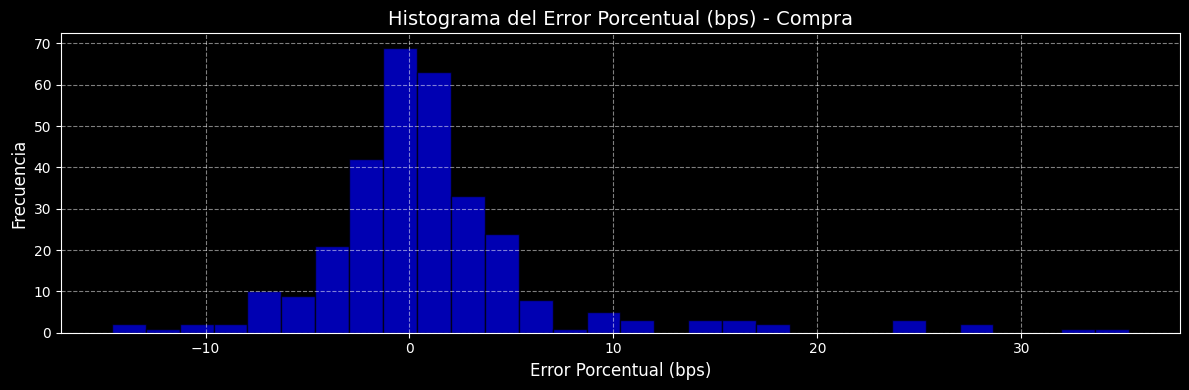

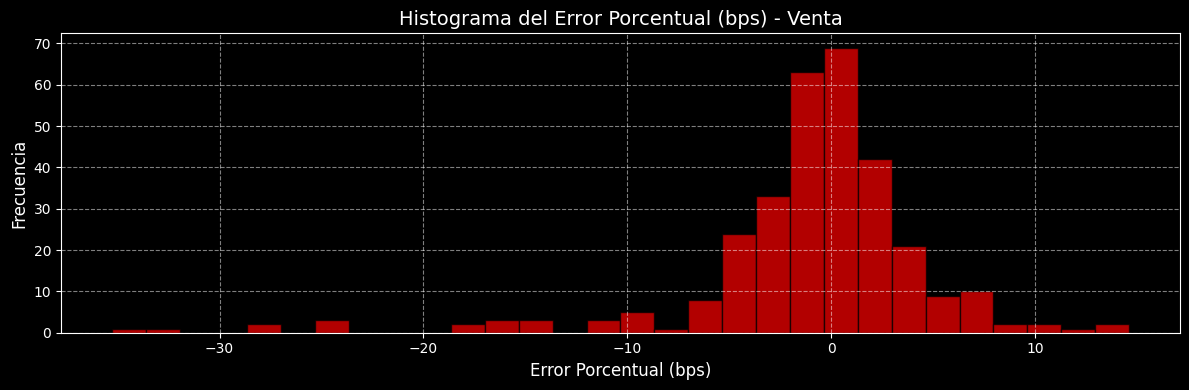


Mejores Casos Dinámicos - Compra:
          date  pcterror_vwap_bps
77  2017-04-21         -14.596153
268 2018-02-06         -14.066731
149 2017-08-07         -12.388983
36  2017-02-21          -9.932871
37  2017-02-22          -9.673858

Peores Casos Dinámicos - Compra:
          date  pcterror_vwap_bps
152 2017-08-10          24.529654
122 2017-06-29          27.795099
301 2018-03-26          28.029449
21  2017-01-31          32.706129
293 2018-03-13          35.282661

Mejores Casos Dinámicos - Venta:
          date  pcterror_vwap_bps
293 2018-03-13         -35.282661
21  2017-01-31         -32.706129
301 2018-03-26         -28.029449
122 2017-06-29         -27.795099
152 2017-08-10         -24.529654

Peores Casos Dinámicos - Venta:
          date  pcterror_vwap_bps
37  2017-02-22           9.673858
36  2017-02-21           9.932871
149 2017-08-07          12.388983
268 2018-02-06          14.066731
77  2017-04-21          14.596153

Tarifa mínima recomendada para Compra (bps): 2.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configurar el estilo de matplotlib para modo oscuro
plt.style.use('dark_background')

# Suponiendo que ya tienes 'algo.resampled_df' con las columnas ['date', 'time_5min', 'volume', 'vwap']
# Si no, asegúrate de cargar y preparar los datos adecuadamente.

# Dividir los datos en entrenamiento y prueba
train_df = algo.resampled_df[algo.resampled_df['date'] < '2017-01-01']
test_df = algo.resampled_df[algo.resampled_df['date'] >= '2017-01-01']

# Definir los parámetros
Q = 0.25 * train_df.groupby('date')['volume'].sum().mean()  # 25% del ADV calculado

# Crear una instancia del predictor de volumen dinámico
vol_predictor = dynamicVolumePredictor(k=5)

# Crear una instancia del algoritmo de ejecución VWAP dinámico para compra
side_buy = 1  # +1 para compra
myalgo_dynamic_buy = dynamic_vwap_algorithm(Q=Q, side=side_buy, vol_predictor=vol_predictor)

# Crear una sesión de backtesting
backtesting = BacktestingSession()

# Ejecutar el backtesting para compra
backtest_results_dynamic_buy = backtesting.run_backtest(algo.resampled_df, myalgo_dynamic_buy, start_date='2017-01-02')

# Calcular el porcentaje de error en basis points (bps) para compra
backtest_results_dynamic_buy['pcterror_vwap_bps'] = 10000 * (backtest_results_dynamic_buy['vwap_algo'] - backtest_results_dynamic_buy['vwap_market']) / backtest_results_dynamic_buy['vwap_market']

# Calcular estadísticas para compra
mean_error_dynamic_buy = backtest_results_dynamic_buy['pcterror_vwap_bps'].mean()
std_error_dynamic_buy = backtest_results_dynamic_buy['pcterror_vwap_bps'].std()
percentiles_dynamic_buy = backtest_results_dynamic_buy['pcterror_vwap_bps'].quantile([0.01, 0.05, 0.95, 0.99])

# Mostrar resultados para compra
print("Resultados para Compra:")
print(f"Error Medio Compra (bps): {mean_error_dynamic_buy:.2f}")
print(f"Desviación Estándar del Error Compra (bps): {std_error_dynamic_buy:.2f}")
print("Percentiles Compra:")
print(percentiles_dynamic_buy)

# Crear una instancia del algoritmo de ejecución VWAP dinámico para venta
side_sell = -1  # -1 para venta
myalgo_dynamic_sell = dynamic_vwap_algorithm(Q=Q, side=side_sell, vol_predictor=vol_predictor)

# Ejecutar el backtesting para venta
backtest_results_dynamic_sell = backtesting.run_backtest(algo.resampled_df, myalgo_dynamic_sell, start_date='2017-01-02')

# Calcular el porcentaje de error en basis points (bps) para venta
backtest_results_dynamic_sell['pcterror_vwap_bps'] = 10000 * (backtest_results_dynamic_sell['vwap_market'] - backtest_results_dynamic_sell['vwap_algo']) / backtest_results_dynamic_sell['vwap_market']

# Calcular estadísticas para venta
mean_error_dynamic_sell = backtest_results_dynamic_sell['pcterror_vwap_bps'].mean()
std_error_dynamic_sell = backtest_results_dynamic_sell['pcterror_vwap_bps'].std()
percentiles_dynamic_sell = backtest_results_dynamic_sell['pcterror_vwap_bps'].quantile([0.01, 0.05, 0.95, 0.99])

# Mostrar resultados para venta
print("\nResultados para Venta:")
print(f"Error Medio Venta (bps): {mean_error_dynamic_sell:.2f}")
print(f"Desviación Estándar del Error Venta (bps): {std_error_dynamic_sell:.2f}")
print("Percentiles Venta:")
print(percentiles_dynamic_sell)

# Comparación entre compra y venta
print("\nComparación entre Compra y Venta:")
print(f"Error Medio Compra (bps): {mean_error_dynamic_buy:.2f}")
print(f"Error Medio Venta  (bps): {mean_error_dynamic_sell:.2f}")

# Crear el histograma para compra
plt.figure(figsize=(12, 4))
plt.hist(backtest_results_dynamic_buy['pcterror_vwap_bps'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma del Error Porcentual (bps) - Compra', fontsize=14)
plt.xlabel('Error Porcentual (bps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Crear el histograma para venta
plt.figure(figsize=(12, 4))
plt.hist(backtest_results_dynamic_sell['pcterror_vwap_bps'], bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Histograma del Error Porcentual (bps) - Venta', fontsize=14)
plt.xlabel('Error Porcentual (bps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Analizar los mejores y peores casos para compra
sorted_results_dynamic_buy = backtest_results_dynamic_buy.sort_values('pcterror_vwap_bps')
best_cases_dynamic_buy = sorted_results_dynamic_buy.head(5)
worst_cases_dynamic_buy = sorted_results_dynamic_buy.tail(5)

print("\nMejores Casos Dinámicos - Compra:")
print(best_cases_dynamic_buy[['date', 'pcterror_vwap_bps']])

print("\nPeores Casos Dinámicos - Compra:")
print(worst_cases_dynamic_buy[['date', 'pcterror_vwap_bps']])

# Analizar los mejores y peores casos para venta
sorted_results_dynamic_sell = backtest_results_dynamic_sell.sort_values('pcterror_vwap_bps')
best_cases_dynamic_sell = sorted_results_dynamic_sell.head(5)
worst_cases_dynamic_sell = sorted_results_dynamic_sell.tail(5)

print("\nMejores Casos Dinámicos - Venta:")
print(best_cases_dynamic_sell[['date', 'pcterror_vwap_bps']])

print("\nPeores Casos Dinámicos - Venta:")
print(worst_cases_dynamic_sell[['date', 'pcterror_vwap_bps']])

# Determinación de la tarifa para un negocio de broker-dealer
desired_profit_bps = 1  # Queremos ganar 1 bps en promedio

# Para compra
required_fee_bps_buy = mean_error_dynamic_buy + desired_profit_bps
print(f"\nTarifa mínima recomendada para Compra (bps): {required_fee_bps_buy:.2f}")

# Para venta
required_fee_bps_sell = mean_error_dynamic_sell + desired_profit_bps
print(f"Tarifa mínima recomendada para Venta (bps): {required_fee_bps_sell:.2f}")


Redo the backtesting analysis from the previous section and compare the results with the static vwap. Which one is better? Which one would you use if you were running a broker-dealer execution business? Why?

In [22]:
# Datos proporcionados
mean_error_buy_static = 1.46
mean_error_sell_static = -1.46
required_fee_bps_buy_static = 2.46
required_fee_bps_sell_static = -0.46

mean_error_buy_dynamic = 1.08
mean_error_sell_dynamic = -1.08
required_fee_bps_buy_dynamic = 2.08
required_fee_bps_sell_dynamic = -0.08

# Comparación de errores medios
print("Comparación de Error Medio (bps):")
print(f"Algoritmo Estático - Compra: {mean_error_buy_static:.2f}")
print(f"Algoritmo Dinámico - Compra: {mean_error_buy_dynamic:.2f}")
print(f"Algoritmo Estático - Venta : {mean_error_sell_static:.2f}")
print(f"Algoritmo Dinámico - Venta : {mean_error_sell_dynamic:.2f}")

# Comparación de tarifas mínimas recomendadas
print("\nComparación de Tarifas Mínimas Recomendadas (bps):")
print(f"Algoritmo Estático - Compra: {required_fee_bps_buy_static:.2f}")
print(f"Algoritmo Dinámico - Compra: {required_fee_bps_buy_dynamic:.2f}")
print(f"Algoritmo Estático - Venta : {required_fee_bps_sell_static:.2f}")
print(f"Algoritmo Dinámico - Venta : {required_fee_bps_sell_dynamic:.2f}")
 

Comparación de Error Medio (bps):
Algoritmo Estático - Compra: 1.46
Algoritmo Dinámico - Compra: 1.08
Algoritmo Estático - Venta : -1.46
Algoritmo Dinámico - Venta : -1.08

Comparación de Tarifas Mínimas Recomendadas (bps):
Algoritmo Estático - Compra: 2.46
Algoritmo Dinámico - Compra: 2.08
Algoritmo Estático - Venta : -0.46
Algoritmo Dinámico - Venta : -0.08
